In [1]:
import sys, os
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFactor = HF(100, 10)

## systematic test 

In [2]:
import numpy as np

In [3]:
from run_systematics import sys_iteration, fitting_SP, sys_ngal, weightmultiply, fitting_allSP, calling_sysMap, maskingCatalogSP

In [4]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
inputdir = rootdir+'/halfNbin/'
figoutdir = inputdir+'/figure/'
sysoutdir = inputdir+'/sys/'
wdir = sysoutdir+'/weights/'

basedir = inputdir+'/act/'
os.system('mkdir '+inputdir+'/act/')

os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+sysoutdir)
os.system('mkdir '+wdir)
#os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

256

In [21]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [23]:
sysMap_fwhm = calling_sysMap( properties=['FWHM'], kind='SPT', nside=4096 )
fwhm_r_hpind = sysMap['sys_FWHM_r_SPT']['PIXEL'][(sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)]
HpIdxInsys_mask4096 = np.in1d(GoldMask_spt['PIXEL'], fwhm_r_hpind)
SPTMaparea_sysmasked = GoldMask_spt[HpIdxInsys_mask4096].size * hp.nside2pixarea(4096, degrees=True)
print 'SPT area:', SPTMaparea
print 'after fwhm_r > 4.5 masked:', SPTMaparea_sysmasked


PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [25]:
print 'SPT area:', SPTMaparea
print 'after fwhm_r > 4.5 masked:', SPTMaparea_sysmasked

SPT area: 1260.9130947509416
after fwhm_r > 4.5 masked: 1235.6146204803479


In [6]:
# import DMASS

#dmass = fitsio.read(rootdir+'spt.fits')
#dmass = io.SearchAndCallFits(path = rootdir, keyword='gold_spt_prob')
dmass = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v2.fits')
#dmass = dmass[dmass['EachProb_CMASS'] > 0.01]
print 'dmass sample size :', np.sum(dmass['EachProb_CMASS'])


#dmass = cutcat20(dmass)
#dmass_st82 = fitsio.read(rootdir+'dmass_st82_0004.fits')
dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob')
#dmass_st82 = dmass_st82[dmass_st82['EachProb_CMASS'] > 0.01]

cmass = fitsio.read(rootdir+'train_sample_des.fits')


print 'dmass st82 sample size :', np.sum(dmass_st82['EachProb_CMASS'])
print 'cmass sample size :', cmass.size


dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass['EachProb_CMASS'])
dmass_st82 = appendColumn(cat = dmass_st82, name='WEIGHT', value=dmass_st82['EachProb_CMASS'])
print np.sum(dmass['EachProb_CMASS']), np.sum(dmass_st82['EachProb_CMASS'])


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v2.fits
dmass sample size : 120874.72753482158

--------------------------------
 calling catalog
--------------------------------
gold_st82_prob.fits
dmass st82 sample size : 13002.574050557929
cmass sample size : 12639
120874.72753482158 13002.574050557929


In [9]:
Ntot = dmass.size
Nexc = np.sum(dmass['EachProb_CMASS'] < 0.005)
Ndiff = Ntot - Nexc
print Ntot, Nexc, Ndiff * 1./Ntot * 100 

6777228 5887701 13.12523350254706


In [10]:
Ntoteff = np.sum(dmass['EachProb_CMASS'])
Nexceff = np.sum(dmass[dmass['EachProb_CMASS'] > 0.005]['EachProb_CMASS'])
Ndiffeff = Ntoteff - Nexceff
print Ntoteff, Nexceff, Ndiffeff * 1./Ntoteff * 100 


120874.72753482158 118747.4249401787 1.7599233835129426


In [11]:
np.sum(dmass['EachProb_CMASS'] > 0.01), np.sum(dmass[dmass['EachProb_CMASS'] > 0.01]['EachProb_CMASS'])

(685616, 117292.90214602613)

In [12]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = dmass.size/10)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = io.SearchAndCallFits(path = rootdir, keyword='random_x50_dmass_spt_masked')
#uniform_random_on_sphere(dmass, size = 10 * dmass.size)
#rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
#rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)


--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt_masked.fits


In [13]:
rand_cmass = uniform_random_on_sphere(cmass, size = 10*cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 10*cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

136044 6777228
10263 12639


# Angular Clustering

In [38]:
#dmass = dmass[dmass['EachProb_CMASS'] > 0.01]
#dmass_st82 = dmass_st82[dmass_st82['EachProb_CMASS'] > 0.01]

In [41]:
#tree corr
from systematics_module.corr import angular_correlation, angular_correlation_poisson
basedir = inputdir+'/act/'
os.system('mkdir '+inputdir+'/act/')
#angular_correlation(data = dmass_st82, rand = rand2_cmass, nbins=10, weight = [True, False], njack = 50, 
#                        suffix = '_dmass_st82_no_weight_nbins10_jk50', dir = basedir)
#angular_correlation(data = dmass, rand = rand, nbins=10, weight = [True, False], njack = 50, 
#                        suffix = '_dmass_no_weight_nbins10_jk50', dir = basedir)

angular_correlation(data = dmass, rand = rand2, nbins=10, weight = [True, False], njack = 50, 
                        suffix = '_dmass_no_weight_pcut00_nbins10_jk50', dir = basedir)

pmask = (dmass['EachProb_CMASS'] > 0.01)
angular_correlation(data = dmass[pmask], rand = rand2, nbins=10, weight = [True, False], njack = 50, 
                        suffix = '_dmass_no_weight_pcut01_nbins10_jk50', dir = basedir)

calculate angular correlation function
X (5206, 2)  centers (50, 2)  tol=1e-05  maxiter=200
51 iterations  cluster sizes: [ 70  74  77 115  97  86 132  84 110 130 108 170  66 103  84 103  83  68
 114 103 127 139 127  87  46  85 104 114 128  72  80  93 112  60 110 126
  82 122  73 118 191 122  84  98 127 147 102 130 108 115]
X (6777228, 2)  centers (50, 2)  tol=1e-05  maxiter=200
116 iterations  cluster sizes: [ 99082 120257 127819 155004 147996 130400 188896 125052 144287 154132
 148524 154813  93375 139048 133988 140639 109198 103674 153031 139688
 136415 142736 144825 124158  53619  93599 149819 154450 140660 127174
 127277 101212 116665 112569 138497 160170 138162 138624 123702 164029
 167225 142363 119626 133862 148420 200984 146098 160664 133371 127350]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_dmass_no_weight_pcut00_nbins10_j

In [43]:
basedir

'../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/'

err db, db / br1, brmin, br2 : 0.026249121038352974 0.009020421295941938 0.9913004263627961 1.0045306448104372 1.0175495474011491
err db, db / br1, brmin, br2 : 0.02152003641069089 0.03699521003078754 1.0080293768759565 1.0188462148537945 1.0295494132866474
err db, db / br1, brmin, br2 : 0.026249121038352974 0.009020421295941938 0.9913004263627961 1.0045306448104372 1.0175495474011491
err db, db / br1, brmin, br2 : 0.023670808676459876 -0.0156652430181885 0.9803020954989783 0.9922282516541626 1.0039729041754382
pic save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//figure/sys_bias.png


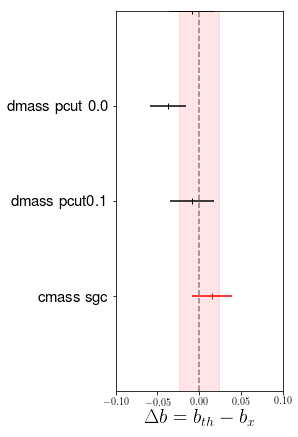

In [51]:
import scipy

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_ngc_interp = scipy.interpolate.interp1d(theta_th, theory)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)

labels_SP = ['dmass_no_weight_pcut00', 'dmass_no_weight_pcut01'] #, 'vetoed'] + ['+ '+o for o in order ]
#labels_SP = ['dmass_st82_no_weight'] #, 'vetoed'] + ['+ '+o for o in order ]
filenames = [ basedir+'acf_auto_'+str(j)+'_nbins10_jk50.txt' for j in labels_SP]
covnames = [ basedir+'acf_auto_'+str(j)+'_nbins10_jk50.cov' for j in labels_SP]

for j in range(0, len(labels_SP)+1):
    
    meanrw, xiw, xi_errw = np.loadtxt( filenames[j-1], unpack=True)
    cov_dmass_w = np.loadtxt( covnames[j-1], unpack=True)
    #meanrw, xiw, xi_errw = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt', unpack=True)
    #cov_dmass_w = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov', unpack=True)
    HFd = 1.0 #HF(100, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp(meanrw), F_d, verbose=True)
    color = 'k'       
    ax.errorbar(2.-2*brelw, len(labels_SP)+1-j, xerr =err_brelw*2., fmt='-|', color=color)



j += 1
meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
HFs = 1.0 #HF(100, 10)
F_s = HFs * np.linalg.inv(cov_cmass_s)
err_brel_sgc, brel_sgc, chisqr_result_sgc = brel_chisqr_fitting(xi_sgc, theory_sgc_interp(meanr_sgc), F_s, verbose=True)

"""
meanr_ngc, xi_ngc, xi_err_ngc = np.loadtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.txt',unpack=True)
cov_cmass_n = np.genfromtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.cov')
HFn = 1.0 #HF(100, 10)
F_n = HFn * np.linalg.inv(cov_cmass_n)
err_brel_ngc, brel_ngc, chisqr_result_ngc = brel_chisqr_fitting(xi_ngc, theory_ngc_interp(meanr_ngc), F_n, verbose=True)
ax.errorbar(2.-2*brel_ngc, len(labels_SP)+1-j-1 , xerr =err_brel_ngc*2., fmt='-|', color='b')
"""



ax.errorbar(2.-2*brel_sgc, len(labels_SP)+1-j , xerr =err_brel_sgc*2., fmt='-|', color='r')
ax.axvspan( - err_brel_sgc*2., err_brel_sgc*2.,  alpha=0.1, color='red')
ax.axvline(x=0.0, color = 'grey', ls='--')
        
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.set_xlim(-0.1+0.02, 0.1+0.02)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(0, len(labels_SP)+1 ))

labels = labels_SP[::-1]
labels = [ 'cmass sgc', 'dmass pcut0.1', 'dmass pcut 0.0']
ax.set_yticklabels( labels, fontsize = 15) 
ax.set_ylim(-1, 3)
ax.set_xlim(-0.1, 0.1)
fig.savefig(figoutdir + 'sys_bias.png')
print 'pic save to ', figoutdir + 'sys_bias.png'



# Systematics 

In [6]:
kind = 'SPT'
FullArea = SPTMaparea
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM']
#properties = ['GE', 'NSTARS_allband']
#properties = ['FWHM']
suffix='no_weight'
# calculating galaxy density and weights iterately

In [7]:
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


KeyboardInterrupt: 

In [16]:
sysMap_nstar = calling_sysMap( properties=['NSTARS_allband'], kind='SPT', nside=4096 )
sysMap_ge = calling_sysMap( properties=['GE'], kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
y1a1_gold_1.0.2_stars_nside1024.fits
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
DOWNGRADE =  1024


In [17]:
sysMap_st82 = calling_sysMap( properties=['GE'], kind='STRIPE82', nside=4096 )

In [18]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

6777228 6641688
mask  0.9800006728414626
136021 133245
mask  0.9795913866241243
20990512 20990512
mask  1.0


### DMASS st82 mocks galactic extinction test 

In [19]:
from systematics_module.contCorrection import doVisualization_ngal

../systematics.py:516: UserWarning: Warning: converting a masked element to nan.
  Ngal = np.array(Ngal)
/n/home00/lee.5922/.local/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//sys/systematic_GE_g_STRIPE82_gold_st82.txt
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//figure/systematic_GE_STRIPE82_gold_st82.png


0

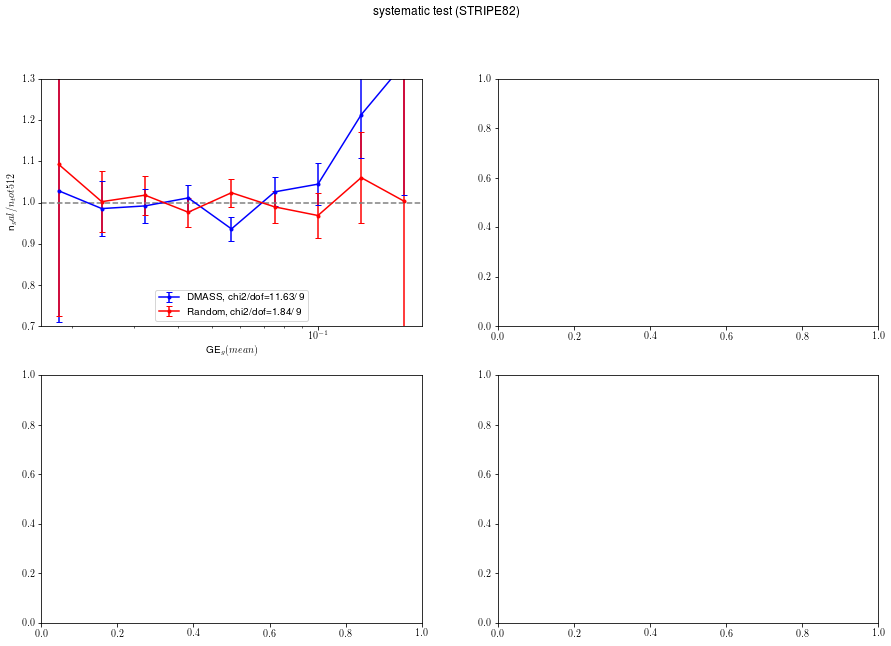

In [52]:

sys_ngal(cat1 = dmass_st82, cat2=rand_cmass, rand1 = rand2_cmass, rand2 = rand2_cmass, sysmap = sysMap_st82, 
     FullArea = SPTMaparea, properties = ['GE'], kind='STRIPE82', nbins =15, 
     nside = 4096,
     suffix='gold_st82', outdir=sysoutdir, reweight = dmass_st82['EachProb_CMASS'])

doVisualization_ngal(property = 'GE', nside = 4096, kind = 'STRIPE82', suffix='gold_st82', \
                     inputdir=sysoutdir, outdir=figoutdir)

saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_GE_SPT_gold_spt.png


0

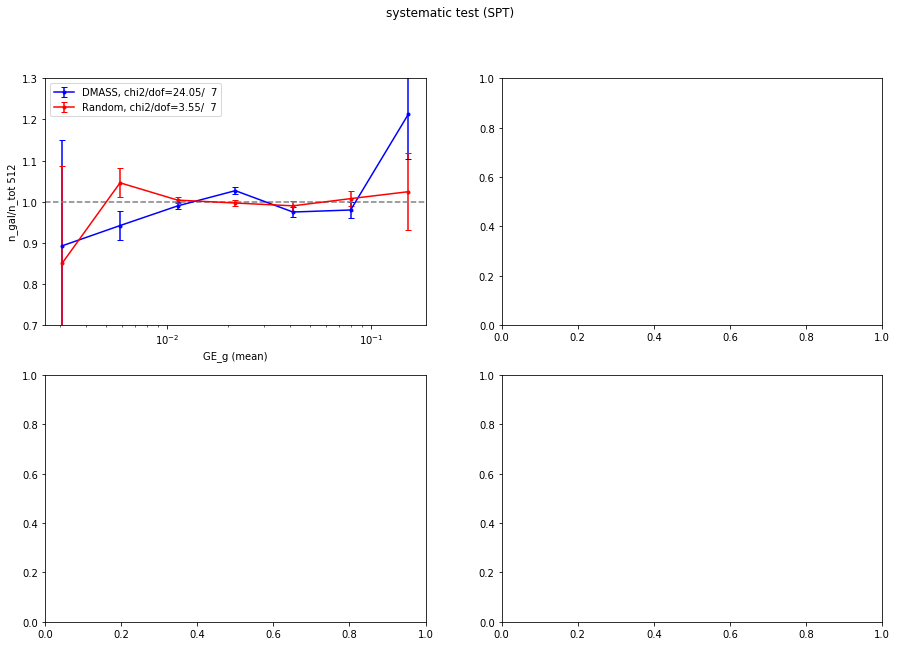

In [12]:
# 15
#sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_ge, 
#         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins =8, 
#         reweight= dmass['EachProb_CMASS'], nside = 4096,
#         suffix='gold_spt', outdir=sysoutdir)

from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 4096, kind = 'SPT', suffix='gold_spt', \
                         inputdir=sysoutdir, outdir=figoutdir)

In [ ]:
# 15
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = properties, kind='SPT', nbins =7, 
         reweight= dmass['EachProb_CMASS'], nside = 4096,
         suffix='no_weight', outdir=sysoutdir)

saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_no_weight.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_no_weight.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_i_SPT_no_weight.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_z_SPT_no_weight.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_EXPTIME_g_SPT_no_weight.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_EXPTIME_r_SPT_no_weight.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_EXPTIME_i_SPT_no_weight.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys

saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_DEPTH_SPT_no_weight.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_EXPTIME_SPT_no_weight.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_AIRMASS_SPT_no_weight.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_SKYBRITE_SPT_no_weight.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_FWHM_SPT_no_weight.png


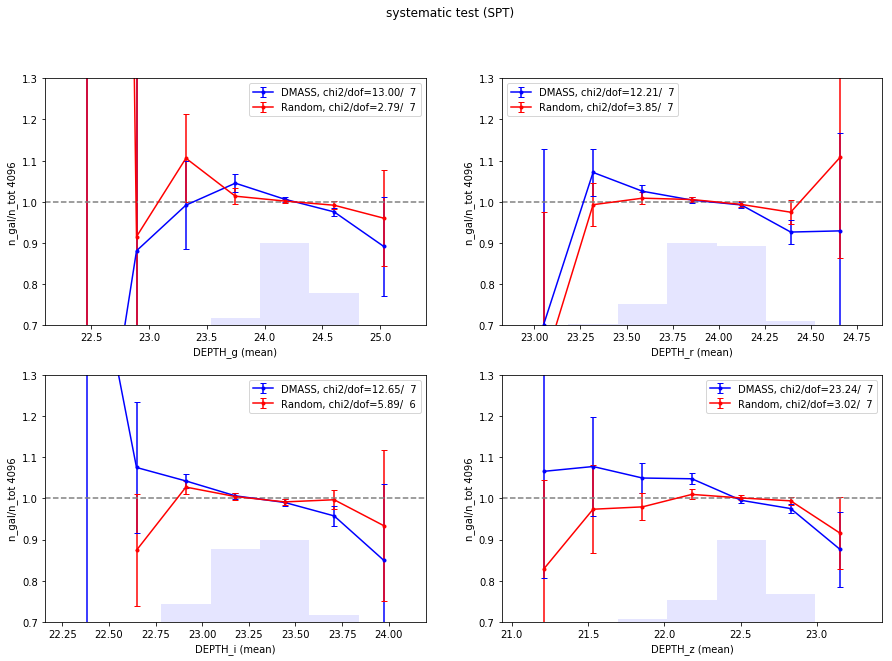

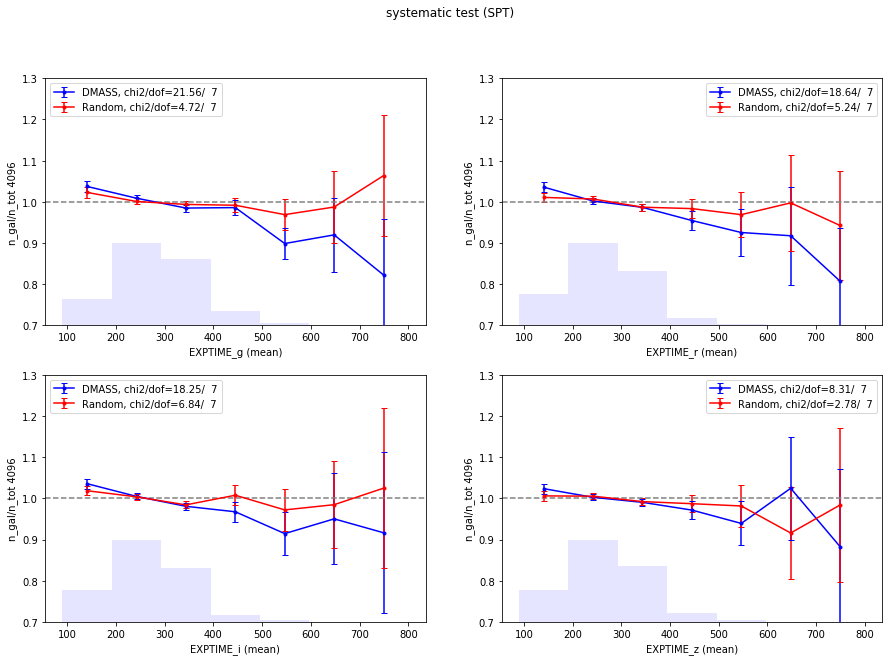

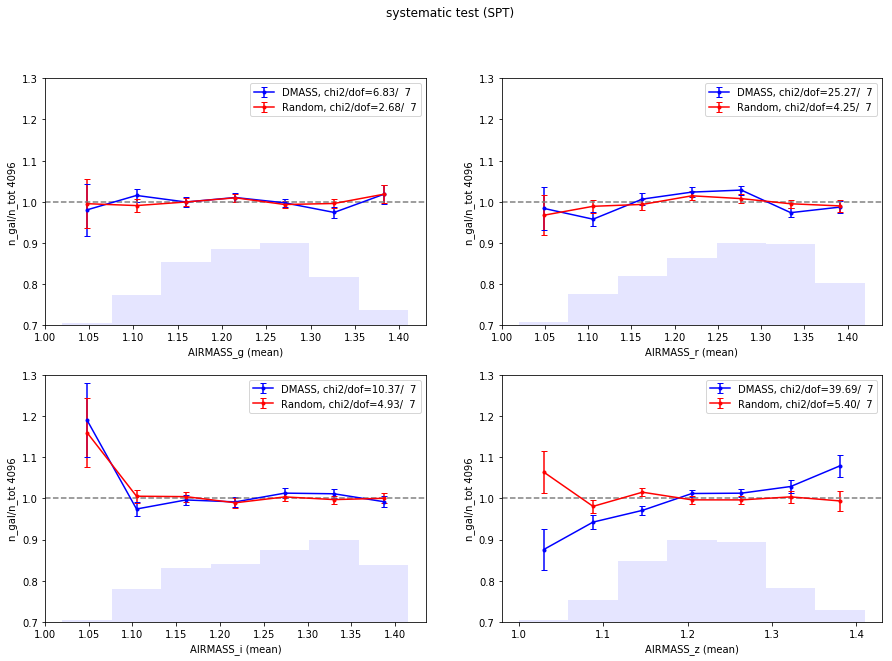

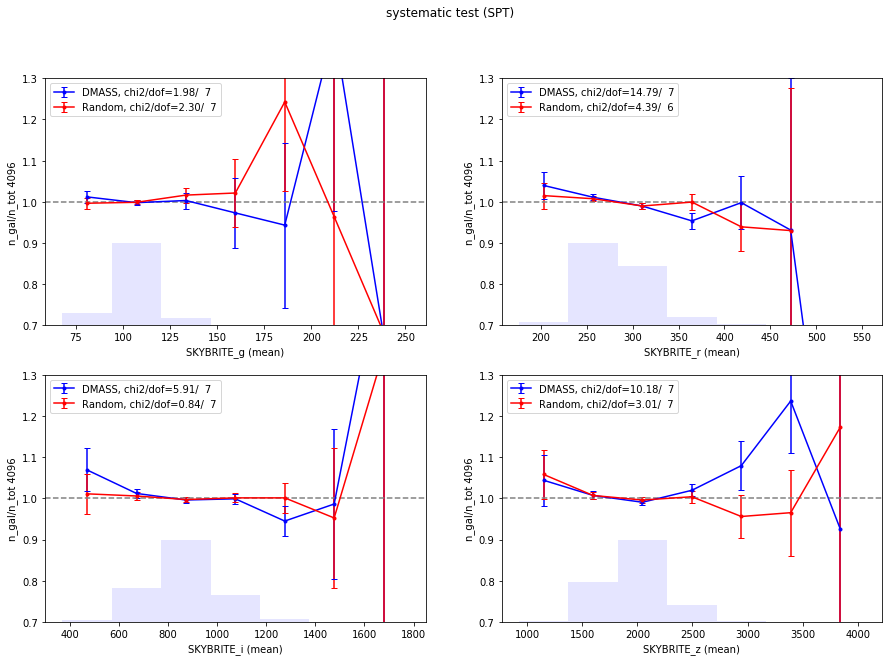

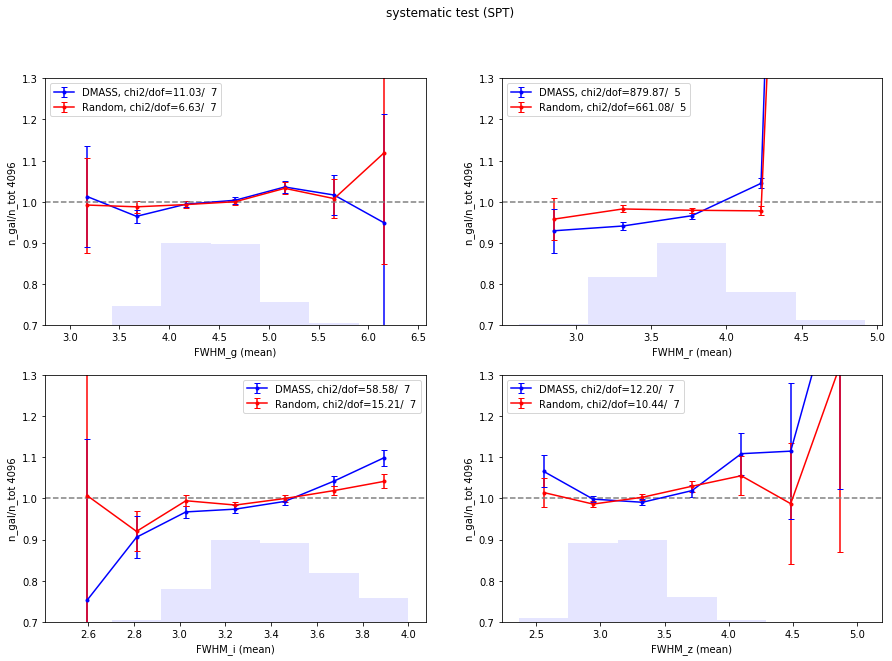

In [19]:
from systematics_module.contCorrection import doVisualization_ngal
for p in properties : 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix='no_weight', \
                         inputdir=sysoutdir, outdir=figoutdir )

In [ ]:
# 15
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['EXPTIME'], kind='SPT', nbins =7, 
         reweight= dmass_masked['EachProb_CMASS'], nside = 4096,
         suffix='vetoed', outdir=sysoutdir)

In [ ]:
# 15
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = properties, kind='SPT', nbins =7, 
         reweight= dmass_masked['EachProb_CMASS'], nside = 4096,
         suffix='vetoed', outdir=sysoutdir)

saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_DEPTH_SPT_vetoed.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_EXPTIME_SPT_vetoed.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_AIRMASS_SPT_vetoed.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_SKYBRITE_SPT_vetoed.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_FWHM_SPT_vetoed.png


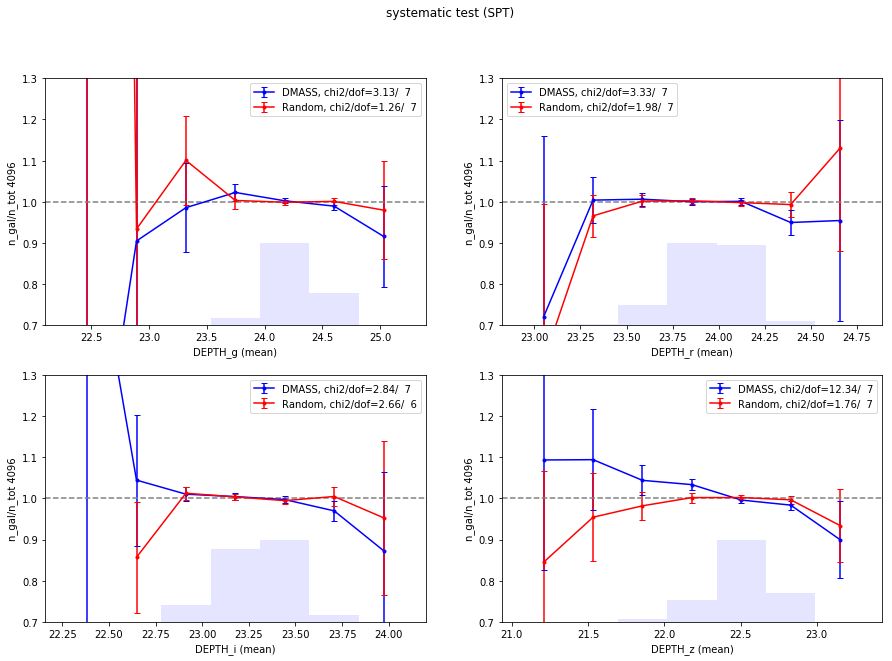

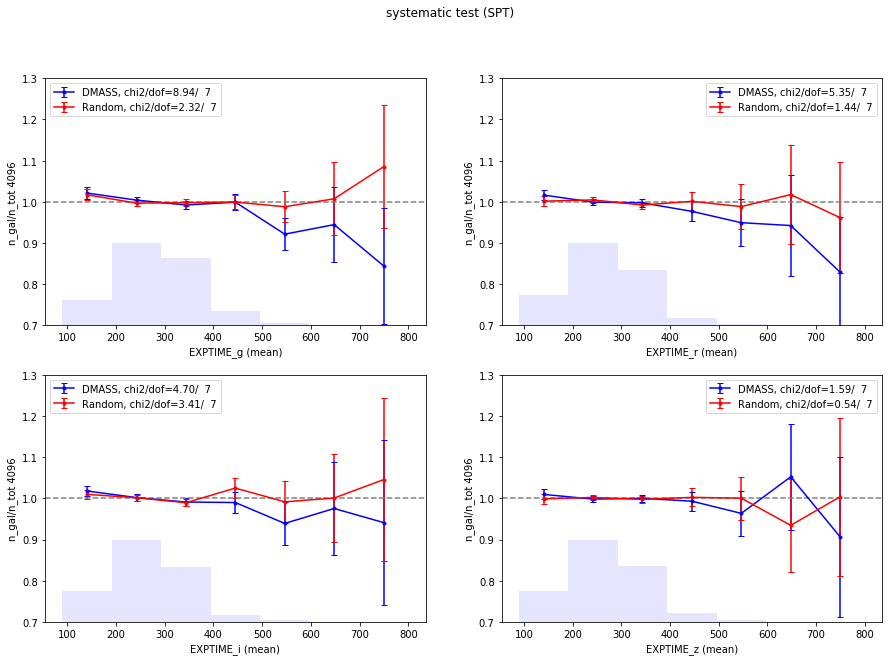

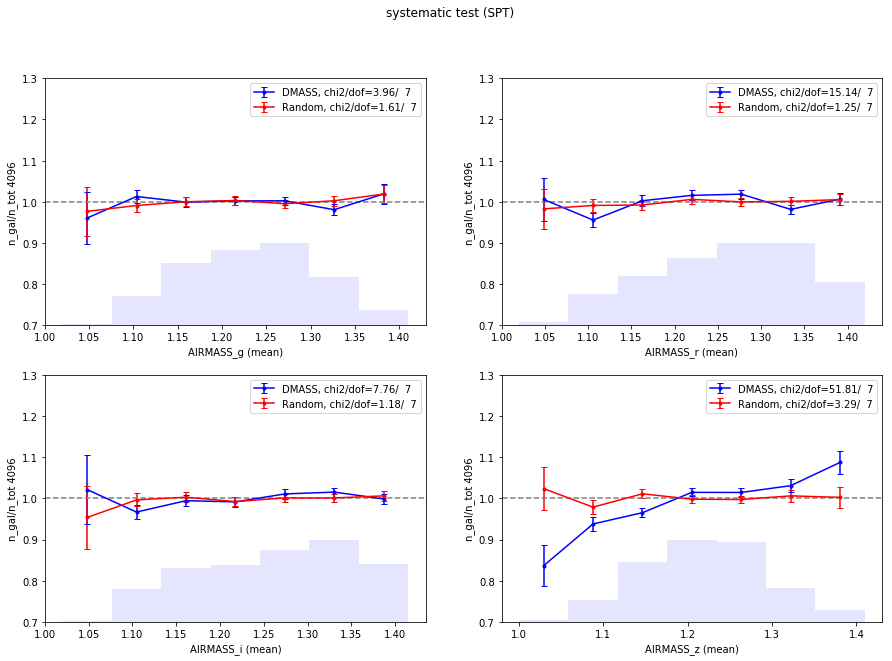

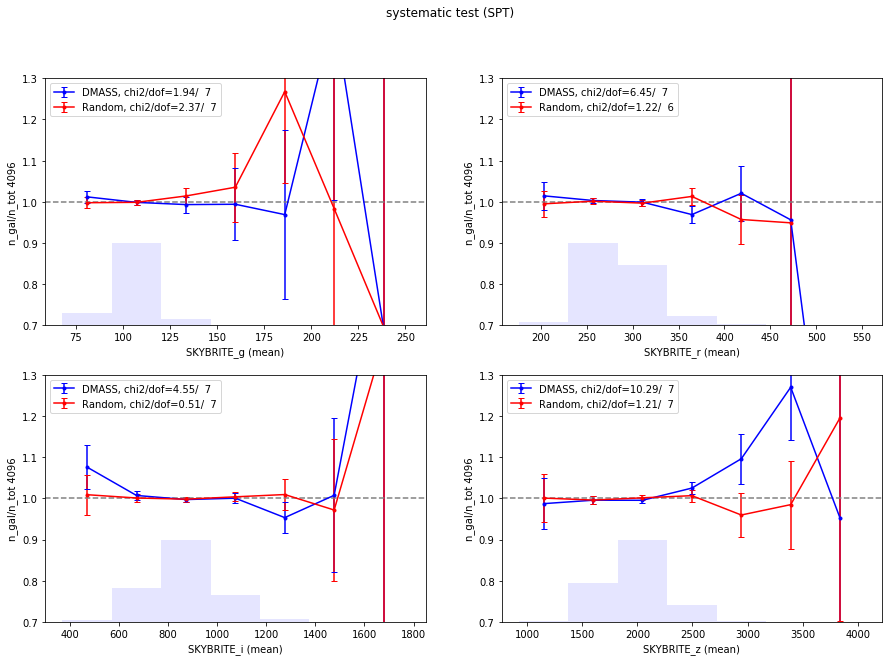

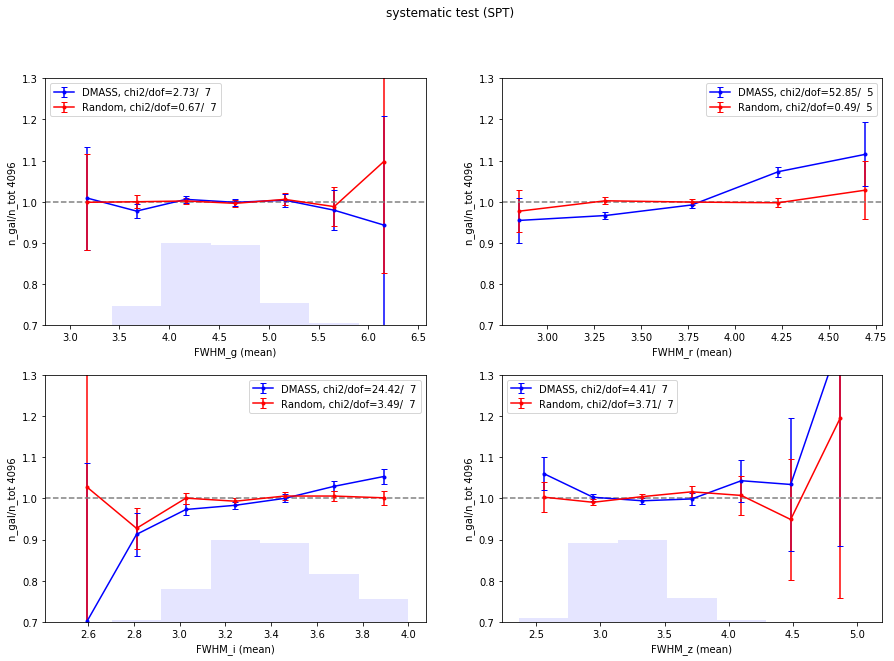

In [20]:
from systematics_module.contCorrection import doVisualization_ngal
for p in properties : 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix='vetoed', \
                         inputdir=sysoutdir, outdir=figoutdir )

In [20]:
# 15

#sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_ge, 
#         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins =15, 
#         reweight= dmass['EachProb_CMASS'], nside = 4096,
#         suffix='no_weight', outdir=sysoutdir)
#sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_nstar, 
#         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins =15, 
#         reweight= dmass['EachProb_CMASS'], nside = 4096,
#         suffix='no_weight', outdir=sysoutdir)
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap_ge, 
         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins =7, 
         reweight= dmass_masked['EachProb_CMASS'], nside = 4096,
         suffix='vetoed', outdir=sysoutdir)
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap_nstar, 
         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins =7, 
         reweight= dmass_masked['EachProb_CMASS'], nside = 4096,
         suffix='vetoed', outdir=sysoutdir)

saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_GE_g_SPT_vetoed.txt
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_NSTARS_allband_g_SPT_vetoed.txt


saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_GE_SPT_vetoed.png
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/systematic_NSTARS_allband_SPT_vetoed.png


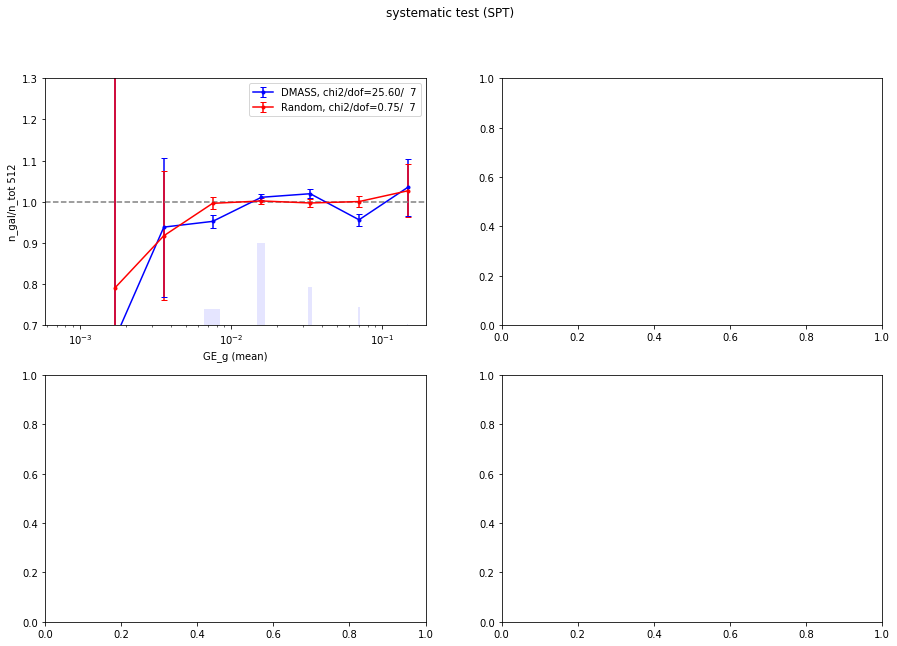

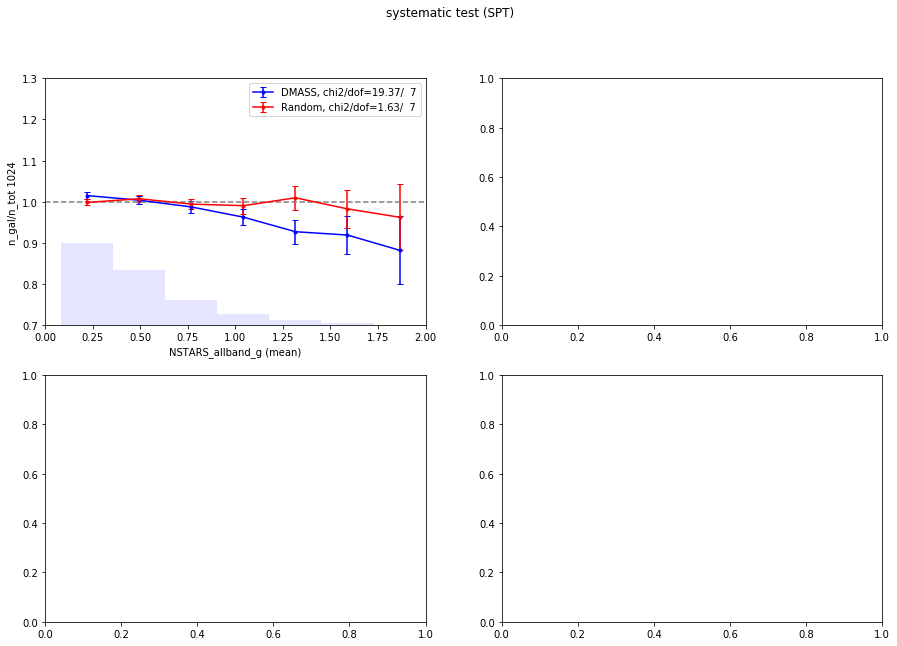

In [21]:

for p in ['GE', 'NSTARS_allband'] : 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix='vetoed', \
                         inputdir=sysoutdir, outdir=figoutdir )

In [22]:
sysoutdir

'../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/'

all linear function
chi2_null =  3.1281517121860247
chi2_mod. =  0.7917762740029546
Delta chi2 (sample) = 2.33637543818307
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_vetoed.txt.model

chi2_null =  3.332178682175576
chi2_mod. =  2.7248475540131722
Delta chi2 (sample) = 0.6073311281624036
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_vetoed.txt.model

chi2_null =  2.8411127715633975
chi2_mod. =  0.8669821455582776
Delta chi2 (sample) = 1.97413062600512
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_i_SPT_vetoed.txt.model

chi2_null =  12.341274951755674
chi2_mod. =  1.7169616108500028
Delta chi2 (sample) = 10.62431334090567
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_z_SPT_vetoed.txt.model

saving fig to  ../output/sfd_train

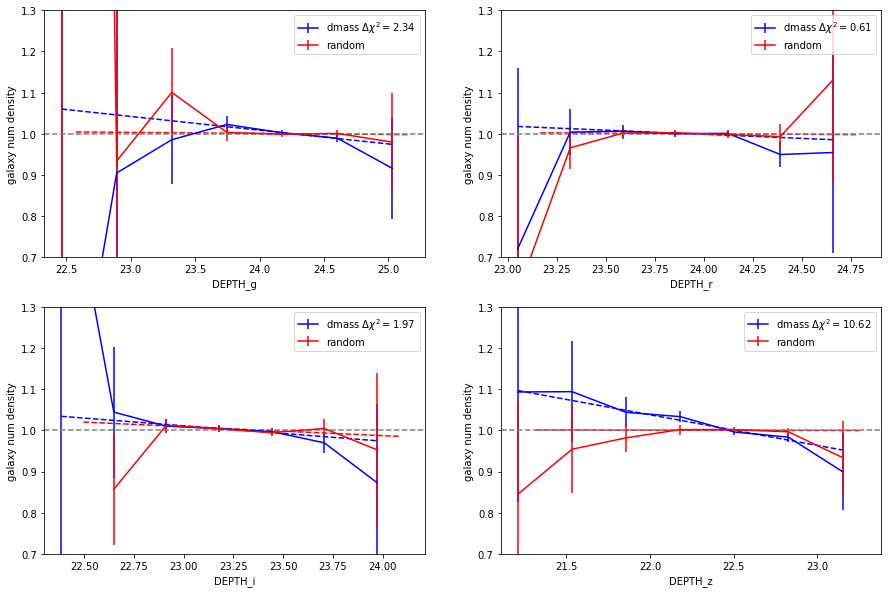

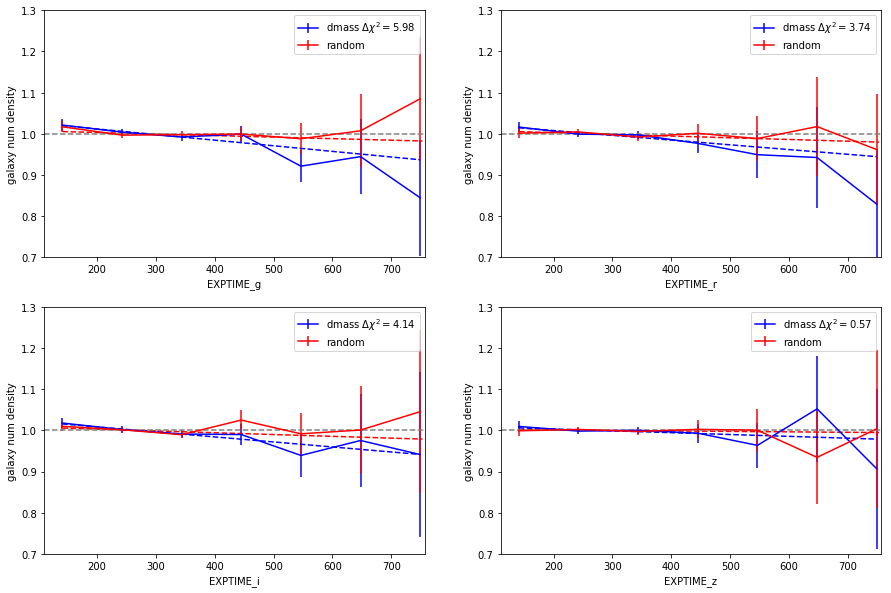

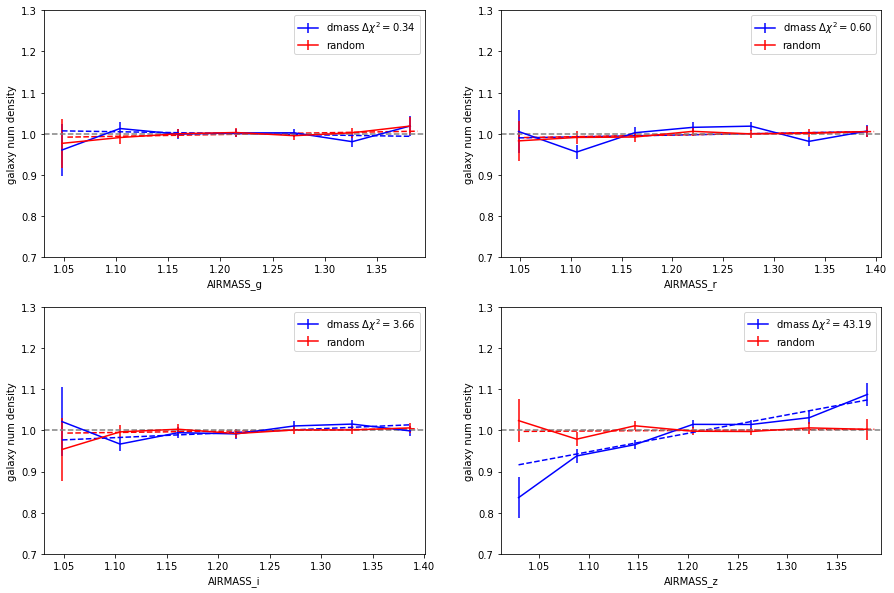

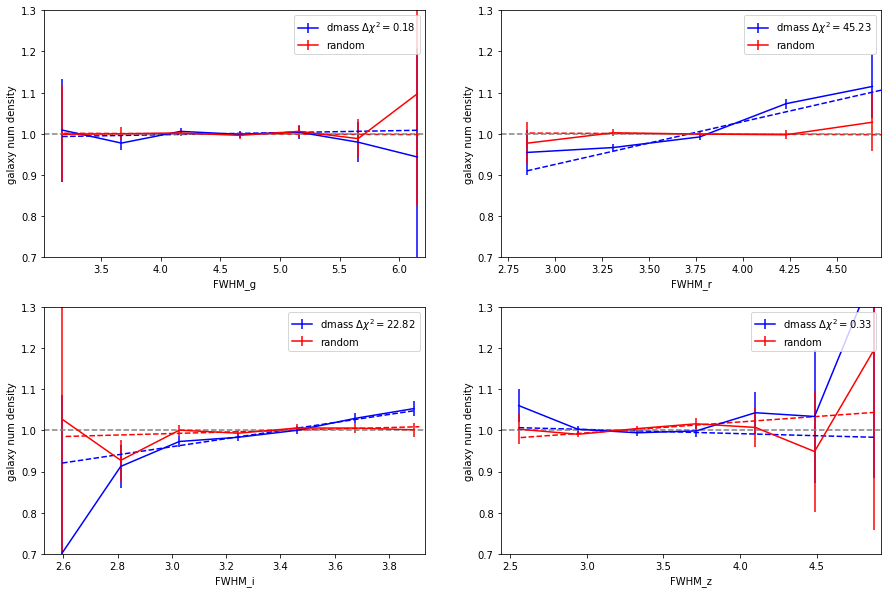

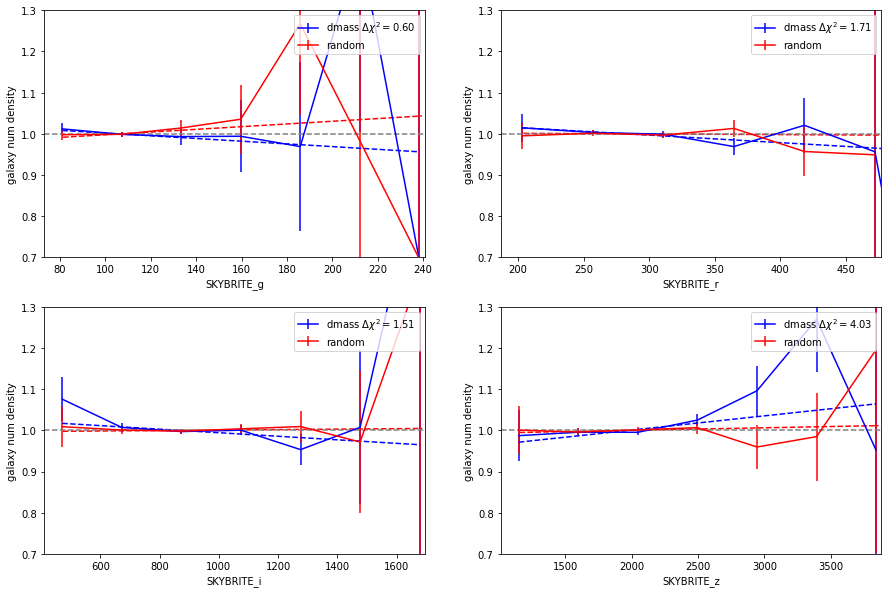

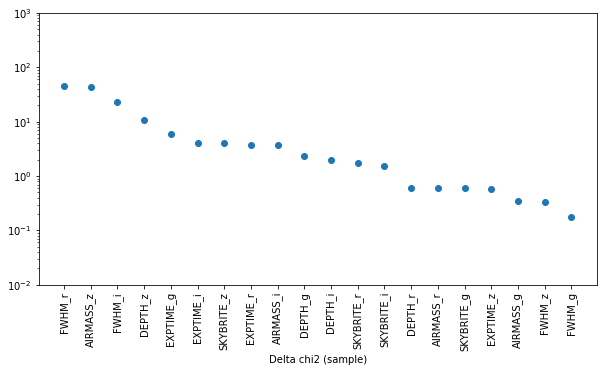

In [13]:
fitting_allSP( 'vetoed', properties = properties, inputdir = sysoutdir )
nextwname, nextw = plotting_significance( property = properties, filter=['g', 'r', 'i', 'z'], kind = 'SPT', 
                      suffix='vetoed', 
                path = sysoutdir, deltachi2=True)

# Correction ! 

### Galactic Extinction

In [14]:
weightDic = {}
weightDic['vetoed'] = dmass['EachProb_CMASS']
all_weight = weightmultiply(weightDic)
suffix = 'vetoed'
nextweight = nextwname[0]
print 'nextweight', nextweight

['vetoed']
vetoed
nextweight FWHM_r


-------------------------
 iteration - 0
 nextweight FWHM_r
-------------------------
['vetoed']
vetoed
sys_iteration
----------------------------------
initialize function  FWHM_r
linear


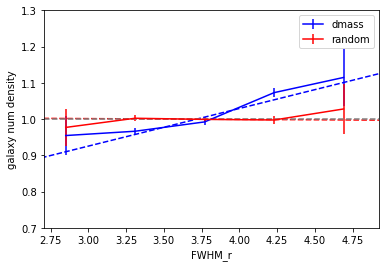

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  FWHM_r
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_fwhm_r_SPT.fits
suffix =  wg_fwhm_r

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r
all linear function
chi2_null =  3.7737508672708135
chi2_mod. =  0.5965880119414808
Delta chi2 (sample) = 3.1771628553293327
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r.txt.model

chi2_null =  3.804748591189424
chi2_mod. =  1.9923299766736928
Delta chi2 (sample) = 1.8124186145157313
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r.txt.model

chi2_null =  4.478090100295783
chi2_mod. =  0.6898684023122866
Delta chi2 (sample) = 3.7882216979834964
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic

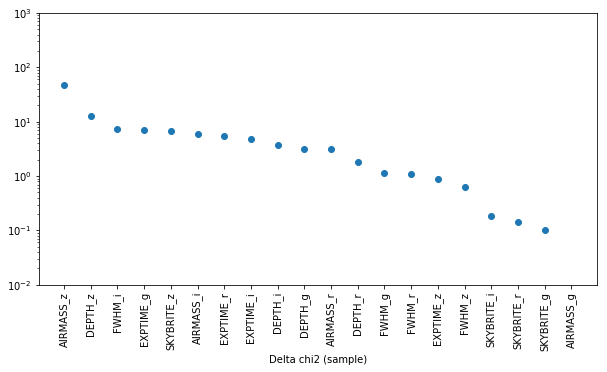

-------------------------
 iteration - 1
 nextweight AIRMASS_z
-------------------------
['vetoed', 'FWHM_r']
vetoed
FWHM_r
sys_iteration
----------------------------------
initialize function  AIRMASS_z
linear


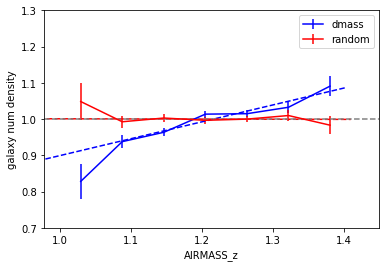

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  AIRMASS_z
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_airmass_z_SPT.fits
suffix =  wg_fwhm_r_airmass_z

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z
all linear function
chi2_null =  5.112415223930434
chi2_mod. =  0.7160123787354752
Delta chi2 (sample) = 4.396402845194959
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z.txt.model

chi2_null =  5.593835158990134
chi2_mod. =  1.51912883094077
Delta chi2 (sample) = 4.0747063280493645
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z.txt.model

chi2_null =  4.761018625849499
chi2_mod. =  0.7589156532620771
Delta chi2 (sample) = 4.002102972587422
output save to  ../output/sfd_train_photo_SamPle_nozband_ran1

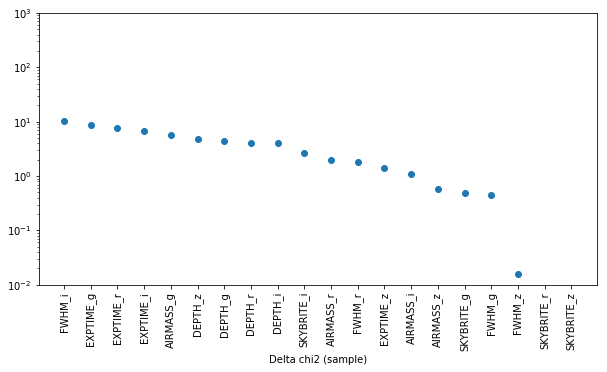

-------------------------
 iteration - 2
 nextweight FWHM_i
-------------------------
['vetoed', 'AIRMASS_z', 'FWHM_r']
vetoed
AIRMASS_z
FWHM_r
sys_iteration
----------------------------------
initialize function  FWHM_i
linear


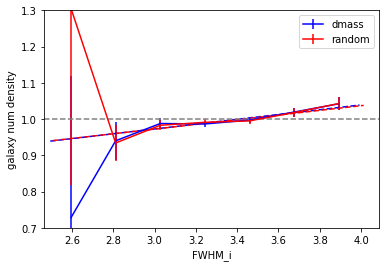

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  FWHM_i
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_fwhm_i_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i
all linear function
chi2_null =  5.286886182687398
chi2_mod. =  0.6814295996732789
Delta chi2 (sample) = 4.605456583014119
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i.txt.model

chi2_null =  5.759673730224687
chi2_mod. =  1.3792580332562974
Delta chi2 (sample) = 4.38041569696839
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_fwhm_i.txt.model

chi2_null =  6.195856479926313
chi2_mod. =  0.6378753344210681
Delta chi2 (sample) = 5.557981145505245
output save to  ../output/sfd_train_pho

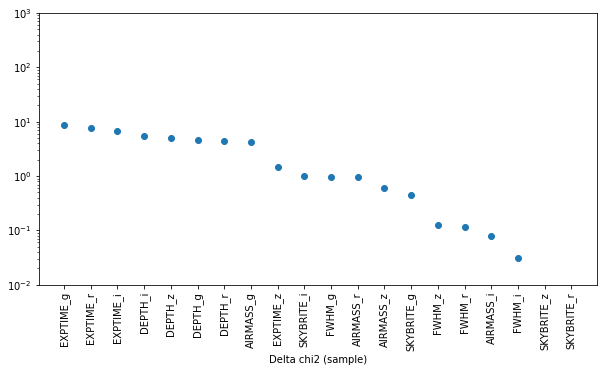

-------------------------
 iteration - 3
 nextweight EXPTIME_g
-------------------------
['vetoed', 'AIRMASS_z', 'FWHM_i', 'FWHM_r']
vetoed
AIRMASS_z
FWHM_i
FWHM_r
sys_iteration
----------------------------------
initialize function  EXPTIME_g
linear


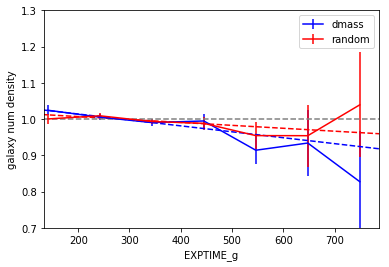

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  EXPTIME_g
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_exptime_g_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g
all linear function
chi2_null =  0.51688782834632
chi2_mod. =  0.5139968074720083
Delta chi2 (sample) = 0.0028910208743117005
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g.txt.model

chi2_null =  1.008225868570175
chi2_mod. =  0.9391142538997346
Delta chi2 (sample) = 0.06911161467044047
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g.txt.model

chi2_null =  0.7242457877669288
chi2_mod. =  0.19860478590096875
Delta chi2 (sample) = 0.5

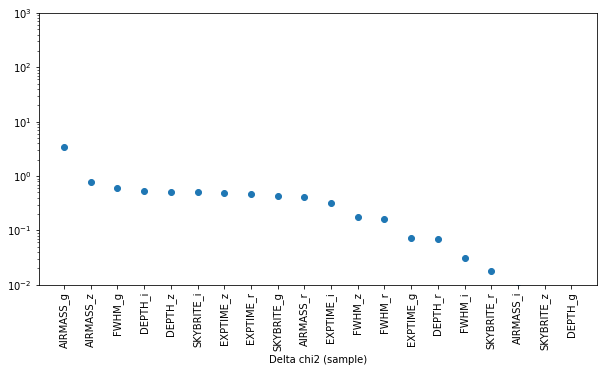

-------------------------
 iteration - 4
 nextweight AIRMASS_g
-------------------------
['EXPTIME_g', 'vetoed', 'AIRMASS_z', 'FWHM_i', 'FWHM_r']
EXPTIME_g
vetoed
AIRMASS_z
FWHM_i
FWHM_r
sys_iteration
----------------------------------
initialize function  AIRMASS_g
linear


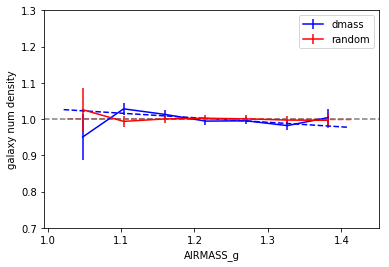

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  AIRMASS_g
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_airmass_g_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g
all linear function
chi2_null =  0.6931400434191546
chi2_mod. =  0.6772741476431703
Delta chi2 (sample) = 0.015865895775984296
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g.txt.model

chi2_null =  0.9855266208925811
chi2_mod. =  0.9842091609584985
Delta chi2 (sample) = 0.0013174599340826099
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g.txt.model

chi2_null =  0.6862373654341
chi2_mod. =  0.16

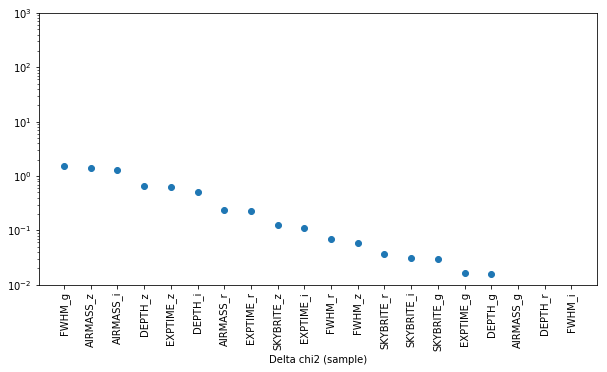

-------------------------
 iteration - 5
 nextweight FWHM_g
-------------------------
['vetoed', 'FWHM_r', 'AIRMASS_z', 'FWHM_i', 'AIRMASS_g', 'EXPTIME_g']
vetoed
FWHM_r
AIRMASS_z
FWHM_i
AIRMASS_g
EXPTIME_g
sys_iteration
----------------------------------
initialize function  FWHM_g
linear


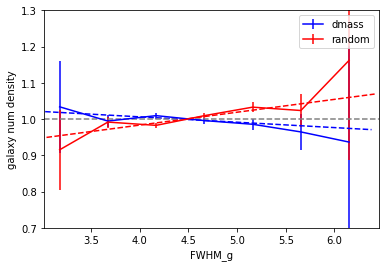

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  FWHM_g
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_fwhm_g_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g
all linear function
chi2_null =  0.7510518961675887
chi2_mod. =  0.7116051531951879
Delta chi2 (sample) = 0.039446742972400806
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.txt.model

chi2_null =  1.0046081709978196
chi2_mod. =  0.9813754876042025
Delta chi2 (sample) = 0.02323268339361717
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.txt.model

chi2_null =  0.74948185557

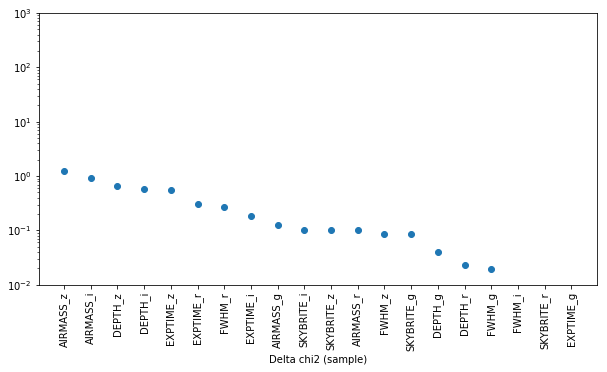

-------------------------
 iteration - 6
 nextweight AIRMASS_i
-------------------------
['vetoed', 'FWHM_g', 'FWHM_r', 'AIRMASS_z', 'FWHM_i', 'AIRMASS_g', 'EXPTIME_g']
vetoed
FWHM_g
FWHM_r
AIRMASS_z
FWHM_i
AIRMASS_g
EXPTIME_g
sys_iteration
----------------------------------
initialize function  AIRMASS_i
linear


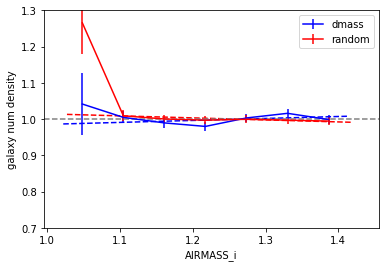

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  AIRMASS_i
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_airmass_i_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i
all linear function
chi2_null =  0.7563620412576967
chi2_mod. =  0.7470328094168192
Delta chi2 (sample) = 0.009329231840877528
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i.txt.model

chi2_null =  1.0324998687766536
chi2_mod. =  0.9594588823380225
Delta chi2 (sample) = 0.0730409864386311
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_ai

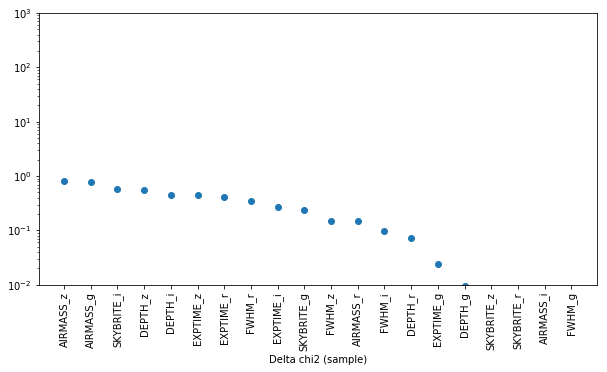

-------------------------
 iteration - 7
 nextweight SKYBRITE_i
-------------------------
['vetoed', 'FWHM_g', 'FWHM_r', 'AIRMASS_z', 'FWHM_i', 'AIRMASS_g', 'AIRMASS_i', 'EXPTIME_g']
vetoed
FWHM_g
FWHM_r
AIRMASS_z
FWHM_i
AIRMASS_g
AIRMASS_i
EXPTIME_g
sys_iteration
----------------------------------
initialize function  SKYBRITE_i
linear


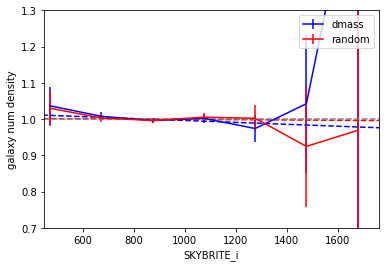

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  SKYBRITE_i
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_skybrite_i_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i
all linear function
chi2_null =  0.741889998262539
chi2_mod. =  0.7219560281482216
Delta chi2 (sample) = 0.019933970114317412
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i.txt.model

chi2_null =  1.0516997057341837
chi2_mod. =  0.9805291291801573
Delta chi2 (sample) = 0.07117057655402637
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_f

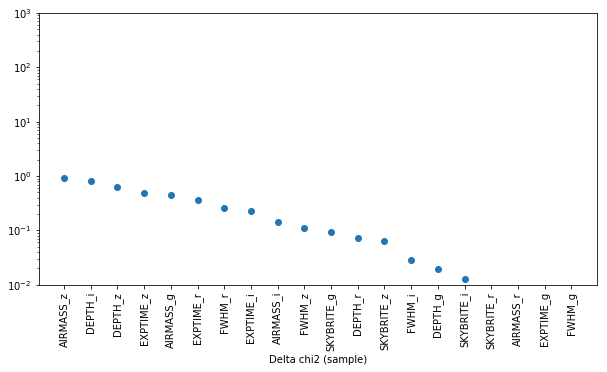

-------------------------
 iteration - 8
 nextweight DEPTH_i
-------------------------
['vetoed', 'FWHM_g', 'FWHM_r', 'AIRMASS_z', 'FWHM_i', 'AIRMASS_g', 'AIRMASS_i', 'SKYBRITE_i', 'EXPTIME_g']
vetoed
FWHM_g
FWHM_r
AIRMASS_z
FWHM_i
AIRMASS_g
AIRMASS_i
SKYBRITE_i
EXPTIME_g
sys_iteration
----------------------------------
initialize function  DEPTH_i
linear


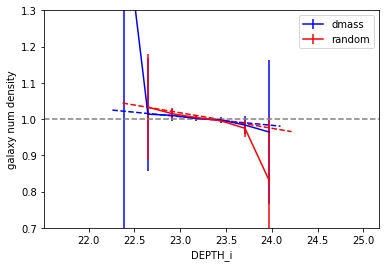

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  DEPTH_i
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_depth_i_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i
all linear function
chi2_null =  1.0039292629005085
chi2_mod. =  0.6864065074953654
Delta chi2 (sample) = 0.3175227554051432
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i.txt.model

chi2_null =  1.057549723419346
chi2_mod. =  0.9695630505646993
Delta chi2 (sample) = 0.08798667285464679
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fw

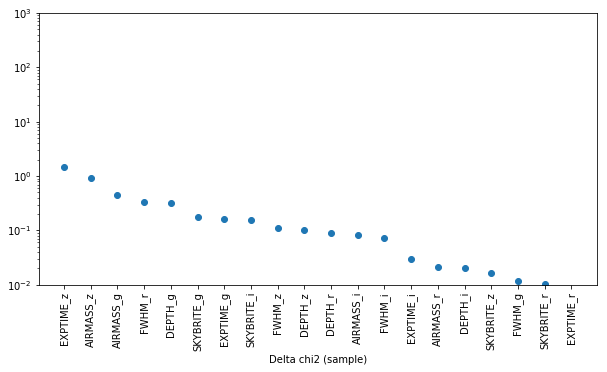

-------------------------
 iteration - 9
 nextweight EXPTIME_z
-------------------------
['DEPTH_i', 'vetoed', 'FWHM_g', 'FWHM_r', 'AIRMASS_z', 'FWHM_i', 'AIRMASS_g', 'AIRMASS_i', 'SKYBRITE_i', 'EXPTIME_g']
DEPTH_i
vetoed
FWHM_g
FWHM_r
AIRMASS_z
FWHM_i
AIRMASS_g
AIRMASS_i
SKYBRITE_i
EXPTIME_g
sys_iteration
----------------------------------
initialize function  EXPTIME_z
linear


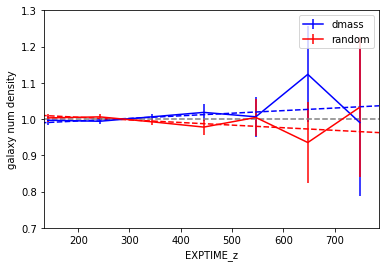

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  EXPTIME_z
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_exptime_z_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z
all linear function
chi2_null =  0.6793847506648512
chi2_mod. =  0.6718270839524464
Delta chi2 (sample) = 0.007557666712404765
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z.txt.model

chi2_null =  1.186820915202897
chi2_mod. =  1.0050703082391703
Delta chi2 (sample) = 0.1817506069637267
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbi

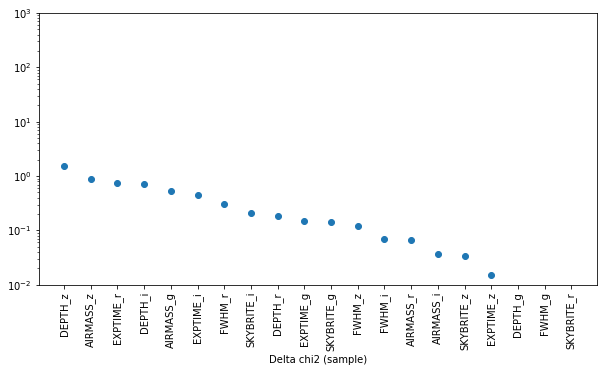

-------------------------
 iteration - 10
 nextweight DEPTH_z
-------------------------
['DEPTH_i', 'vetoed', 'FWHM_g', 'FWHM_r', 'AIRMASS_z', 'EXPTIME_z', 'FWHM_i', 'AIRMASS_g', 'AIRMASS_i', 'SKYBRITE_i', 'EXPTIME_g']
DEPTH_i
vetoed
FWHM_g
FWHM_r
AIRMASS_z
EXPTIME_z
FWHM_i
AIRMASS_g
AIRMASS_i
SKYBRITE_i
EXPTIME_g
sys_iteration
----------------------------------
initialize function  DEPTH_z
linear


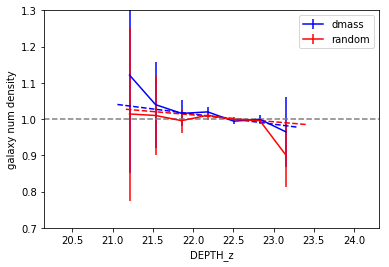

6777228 6641688
mask  0.9800006728414626
cutting out  135540
store weight  DEPTH_z
save weight to fits ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys//weights/wg_depth_z_SPT.fits
suffix =  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z_depth_z

sys_ngal : 
the number of bins= 7
fitting_allSP
suffix  wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z_depth_z
all linear function
chi2_null =  0.79672573555775
chi2_mod. =  0.6065291780255346
Delta chi2 (sample) = 0.19019655753221532
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z_depth_z.txt.model

chi2_null =  1.0632833189012598
chi2_mod. =  1.0249816277408428
Delta chi2 (sample) = 0.03830169116041704
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_f

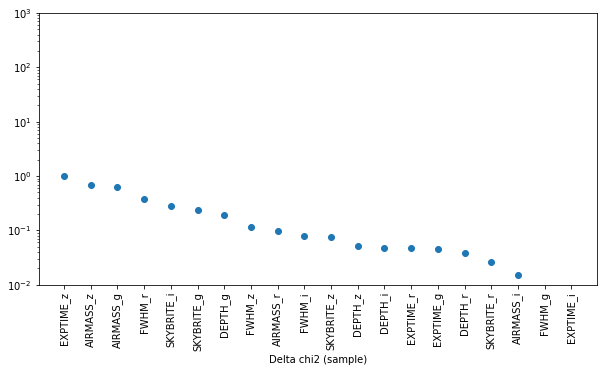

-------------------------
 iteration - 11
 nextweight FWHM_r
-------------------------
['DEPTH_i', 'vetoed', 'FWHM_g', 'FWHM_r', 'AIRMASS_z', 'EXPTIME_z', 'FWHM_i', 'DEPTH_z', 'AIRMASS_g', 'AIRMASS_i', 'SKYBRITE_i', 'EXPTIME_g']
DEPTH_i
vetoed
FWHM_g
FWHM_r
AIRMASS_z
EXPTIME_z
FWHM_i
DEPTH_z
AIRMASS_g
AIRMASS_i
SKYBRITE_i
EXPTIME_g
sys_iteration
----------------------------------
initialize function  FWHM_r
linear


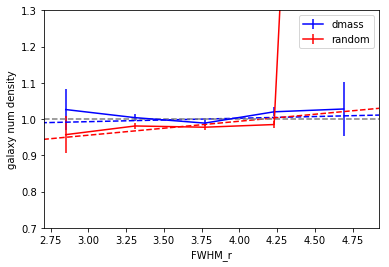

KeyboardInterrupt: 

In [24]:
applied_weight = []
for ii in range(21):
    
    #nextweight = 'AIRMASS_g'
    print '-------------------------'
    print ' iteration -', ii
    print ' nextweight', nextweight
    print '-------------------------'
    #if ii < 7 : pp = []
    #else : pp = properties
    all_weight = weightmultiply(weightDic)
    function = 'linear'
    #if nextweight == 'SKYBRITE_i': function = 'errftn'
    
    print 'sys_iteration'
    sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                      cat1=dmass, cat2=rand, rand1 = rand2, rand2=rand2,
                      sysMap = sysMap, nside=4096, kind='SPT', function=function, function2 = None,
                      properties = [], filters=['g', 'r', 'i', 'z'],
                      path=sysoutdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )
    
    if suffix == 'vetoed': suffix = 'wg_'+nextweight.lower()
    else : suffix = suffix+'_'+nextweight.lower()
        
    #print 'suffix', suffix, nextweight
    
    print 'fitting_allSP'
    print 'suffix ', suffix
    fitting_allSP( suffix, properties = properties, inputdir = sysoutdir, plot=False )
    nextwname, nextw = plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                          suffix=suffix, 
                    path = sysoutdir, deltachi2=True)
    
    nextweight = nextwname[0]
    for i in range(1,len(nextwname)):
        if nextweight in applied_weight :
            nextweight = nextwname[i]
        else : break
    applied_weight.append(nextweight)



In [ ]:
ls ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_

# Appling weights 

In [ ]:
#wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z_depth_z

In [113]:
suffix

'wg_fwhm_r_airmass_z_exptime_g_fwhm_i_airmass_g_fwhm_g'

In [32]:
suf = 'wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i'
#suf = 'wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g_airmass_i_skybrite_i_depth_i_exptime_z_depth_z'

orderlabel = suf.split('_')[1:]
order = []
for i in np.arange(0, len(orderlabel), 2):
    order.append( orderlabel[i]+'_'+orderlabel[i+1] )
print order

weightDic_re = {}
weightDic_re['vetoed'] = dmass['EachProb_CMASS']
maskhp = maskingCatalogSP(catalog=dmass, maskonly=True, sysMap=sysMap)
weightDic_re['vetoed'][~maskhp] = 0 
for o in order : 
    w = fitsio.read(sysoutdir+'weights/wg_'+o+'_SPT.fits')
    weightDic_re[o] = w #[maskhp]
    
all_weight = weightmultiply(weightDic_re)

['fwhm_r', 'airmass_z', 'fwhm_i', 'exptime_g', 'airmass_g', 'fwhm_g', 'airmass_i', 'skybrite_i']


NameError: name 'sysMap' is not defined

In [28]:
weights = dmass['CMASS_PROB'] * dmass['VETO']

#15
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_ge, 
         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins =7, 
         reweight= weights, nside = 4096,
         suffix='vetoed', outdir=sysoutdir)
#10
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_nstar, 
         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins =7, 
         reweight= weights, nside = 4096,
         suffix='vetoed', outdir=sysoutdir)


sys_ngal : 
the number of bins= 7
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_GE_g_SPT_vetoed.txt

sys_ngal : 
the number of bins= 7
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_NSTARS_allband_g_SPT_vetoed.txt


In [29]:
#weights = all_weight

# 15
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_ge, 
         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins =7, 
         reweight= all_weight, nside = 4096,
         suffix=suf, outdir=sysoutdir)
#10
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_nstar, 
         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins =7, 
         reweight= all_weight, nside = 4096,
         suffix=suf, outdir=sysoutdir)


sys_ngal : 
the number of bins= 7
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_GE_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.txt

sys_ngal : 
the number of bins= 7
saving data to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_NSTARS_allband_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.txt


In [30]:
fitting_allSP( suf, properties = properties+['GE', 'NSTARS_allband'], inputdir = sysoutdir, plot=False )
fitting_allSP( 'vetoed', properties = properties+['GE', 'NSTARS_allband'], inputdir = sysoutdir, plot=False )

all linear function
chi2_null =  0.7510518961675887
chi2_mod. =  0.7116051531951879
Delta chi2 (sample) = 0.039446742972400806
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.txt.model

chi2_null =  1.0046081709978196
chi2_mod. =  0.9813754876042025
Delta chi2 (sample) = 0.02323268339361717
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.txt.model

chi2_null =  0.7494818555761062
chi2_mod. =  0.1706087002443945
Delta chi2 (sample) = 0.5788731553317117
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.txt.model

chi2_null =  2.861993666174057
chi2_mod. =  2.216499304872571
Delta chi2 (sample) = 0.6454943613014859
output save to  ../

output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_FWHM_i_SPT_vetoed.txt.model

chi2_null =  4.409747771161924
chi2_mod. =  4.079055692036576
Delta chi2 (sample) = 0.33069207912534804
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_FWHM_z_SPT_vetoed.txt.model

chi2_null =  1.9413397138821142
chi2_mod. =  1.3451959054965774
Delta chi2 (sample) = 0.5961438083855368
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_SKYBRITE_g_SPT_vetoed.txt.model

chi2_null =  6.451304238458584
chi2_mod. =  4.736607037856295
Delta chi2 (sample) = 1.7146972006022887
output save to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/systematic_SKYBRITE_r_SPT_vetoed.txt.model

chi2_null =  4.548970119253474
chi2_mod. =  3.036493410166212
Delta chi2 (sample) = 1.5124767090872622
output save to  ../output/sfd_train_photo_SamPle_

----------------------------------
initialize function  DEPTH_g
linear


KeyError: 'sys_DEPTH_g_SPT'

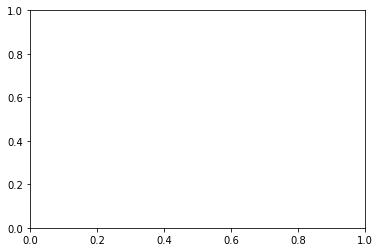

In [74]:

"""
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap_nstar, nside=4096, kind='SPT', function=function, function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=sysoutdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

if suffix == 'vetoed': suffix = 'wg_'+nextweight.lower()
else : suffix = suffix+'_'+nextweight.lower()

fitting_allSP( suffix, properties = properties[:-2], inputdir = sysoutdir, plot=False )
nextwname, nextw = plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = sysoutdir, deltachi2=True)
                
"""

In [31]:
filters = ['g', 'r', 'i', 'z']

[45.23377177211485, 43.193963500807925, 22.817461872715803, 10.62431334090567, 5.97938848251715, 4.140790976738564, 4.033291708661969, 3.7446073139226357, 3.6624121572329367, 2.33637543818307, 1.97413062600512, 1.7146972006022887, 1.5124767090872622, 0.6073311281624036, 0.5981909467997006, 0.5961438083855368, 0.5715812882271423, 0.3440945212787536, 0.33069207912534804, 0.18001490515841478, 0.017705651034948033]


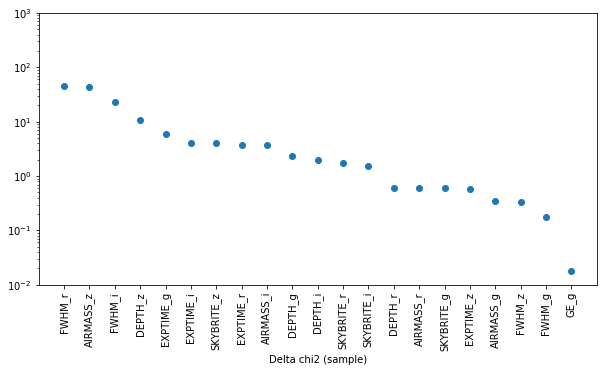

[1.2599449922630042, 0.910365027107094, 0.7876139678920708, 0.6454943613014859, 0.5788731553317117, 0.5481118197879693, 0.3009745800932928, 0.273665004850395, 0.18565682391973704, 0.12551948972023297, 0.10321009343012899, 0.10286131268833554, 0.10144314451766023, 0.08726728562425468, 0.08669906428507601, 0.039446742972400806, 0.02323268339361717, 0.019144183019346173, 0.008376484458267885, 0.007500064685137531, 0.0010600340761630633]


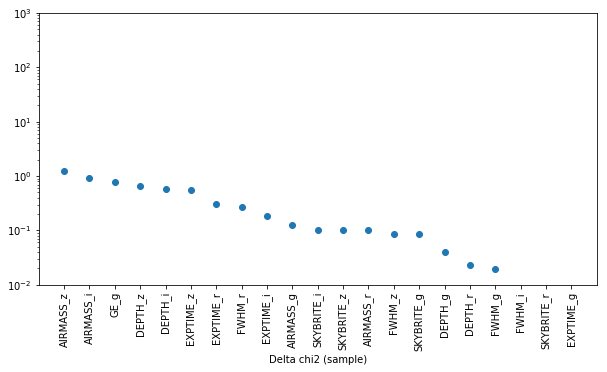

In [32]:
label_no_weight, values_no_weight = plotting_significance( property = properties+['GE'], filter=filters, kind = kind, suffix='vetoed', 
                    path = sysoutdir, deltachi2=True)
label_full_weight, values_full_weight = plotting_significance( property = properties+['GE'], filter=filters, kind = kind, suffix=suf, 
                    path = sysoutdir, deltachi2=True)
#label_full_weight2, values_full_weight2 = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suf2, 
#                    path = inputdir, deltachi2=True)

0

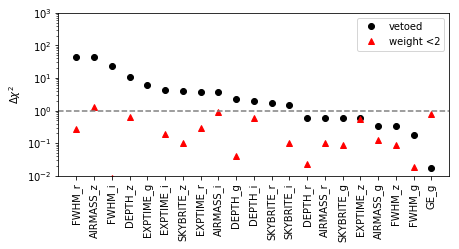

In [85]:

values_full_weight_reorder = []
for la in label_no_weight:
    for j in range(len(label_full_weight)):
        if la == label_full_weight[j]: 
            values_full_weight_reorder.append(values_full_weight[j])
            break
"""
values_full_weight_reorder2 = []
for la in label_no_weight:
    for j in range(len(label_full_weight2)):
        if la == label_full_weight2[j]: 
            values_full_weight_reorder2.append(values_full_weight2[j])
            break
"""           
values_full_weight_reorder = np.array(values_full_weight_reorder)
#values_full_weight_reorder2 = np.array(values_full_weight_reorder2)

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(values_no_weight) ), values_no_weight,  'ko' , label='vetoed'  )
ax.plot( np.arange( len(values_no_weight) ), values_full_weight_reorder, 'r^', label='weight <2'  )
#ax.plot( np.arange( len(values_no_weight) ), values_full_weight_reorder2, 'b^', label='weight <1'  )


#ax.plot( values_no_weight, np.arange( len(values_no_weight) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_weight) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 1, ls = '--', color='grey')
#ax.axhline(y = 1, ls = '--', color='grey')
ax.set_ylim(0.01,1000)
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xticks( np.arange(len(values_no_weight)))
ax.set_xticklabels(label_no_weight, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')

#fig.savefig(inputdir+'comparison3_chisquare_'+suf+'.png')
0

In [86]:
suf

'wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g'

In [34]:
paperpic =  '../paper_figure/halfNbin/'
os.mkdir(paperpic)

In [91]:
sysoutdir

'../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//sys/'

In [88]:
help(plot_sysweight_one)

Help on function plot_sysweight_one in module run_systematics:

plot_sysweight_one(property=None, filter='g', nside=1024, kind='SPT', xlabel=None, ylabel='averaged Ng', suffix1='', suffix2='', inputdir1='.', inputdir2='.', outdir='./', hist=False)



stellar density
saving fig to  ../paper_figure/halfNbin/comparison_systematic_NSTARS_allband_g.pdf
None
saving fig to  ../paper_figure/halfNbin/comparison_systematic_GE_g.pdf
None
saving fig to  ../paper_figure/halfNbin/comparison_systematic_FWHM_r.pdf
None
saving fig to  ../paper_figure/halfNbin/comparison_systematic_AIRMASS_z.pdf
None
saving fig to  ../paper_figure/halfNbin/comparison_systematic_EXPTIME_g.pdf
None
saving fig to  ../paper_figure/halfNbin/comparison_systematic_FWHM_i.pdf
None
saving fig to  ../paper_figure/halfNbin/comparison_systematic_AIRMASS_g.pdf
None
saving fig to  ../paper_figure/halfNbin/comparison_systematic_FWHM_g.pdf


0

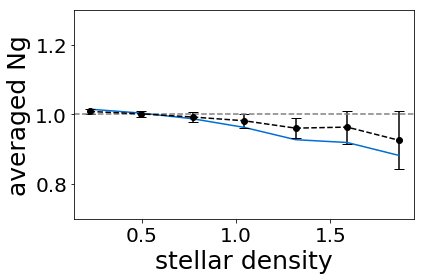

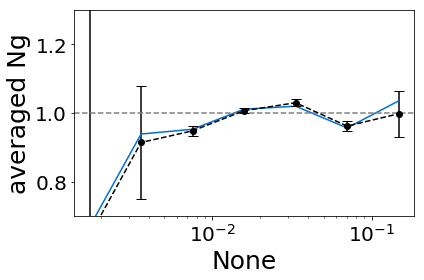

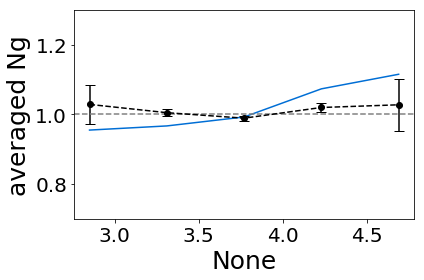

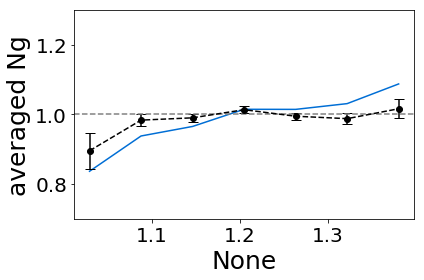

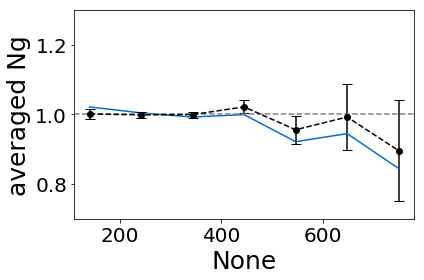

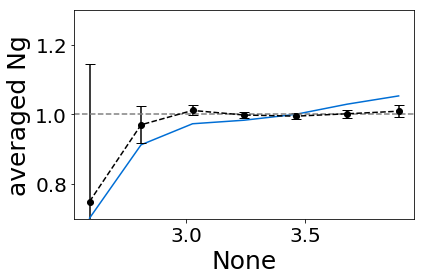

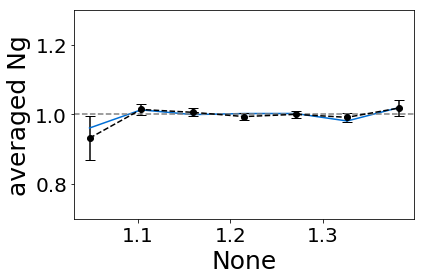

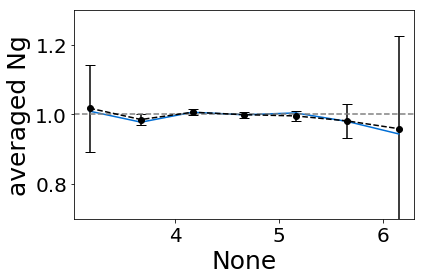

In [89]:
from run_systematics import plot_sysweight_one
plot_sysweight_one(property = 'NSTARS_allband', xlabel = 'stellar density' , ylabel=r'', 
                   nside = 1024, kind = 'SPT', 
                   suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

plot_sysweight_one(property = 'GE', nside = 1024, kind = 'SPT', 
           suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

plot_sysweight_one(property = 'FWHM', filter='r', nside = 1024, kind = 'SPT', 
           suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

plot_sysweight_one(property = 'AIRMASS', filter='z', nside = 1024, kind = 'SPT', 
           suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

plot_sysweight_one(property = 'EXPTIME', filter='g', nside = 1024, kind = 'SPT', 
           suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

plot_sysweight_one(property = 'FWHM', filter='i', nside = 1024, kind = 'SPT', 
           suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

plot_sysweight_one(property = 'AIRMASS', filter='g', nside = 1024, kind = 'SPT', 
           suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

plot_sysweight_one(property = 'FWHM', filter='g', nside = 1024, kind = 'SPT', 
           suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=paperpic)

In [37]:
figoutdir

'../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/'

saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/comparison_systematic_DEPTH_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.pdf
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/comparison_systematic_EXPTIME_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.pdf
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/comparison_systematic_AIRMASS_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.pdf
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/comparison_systematic_SKYBRITE_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.pdf
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//figure/comparison_systematic_FWHM_SPT_wg_fwhm_r_airmass_z_fwhm_i_exptime_g_airmass_g_fwhm_g.pdf
saving fig to  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e

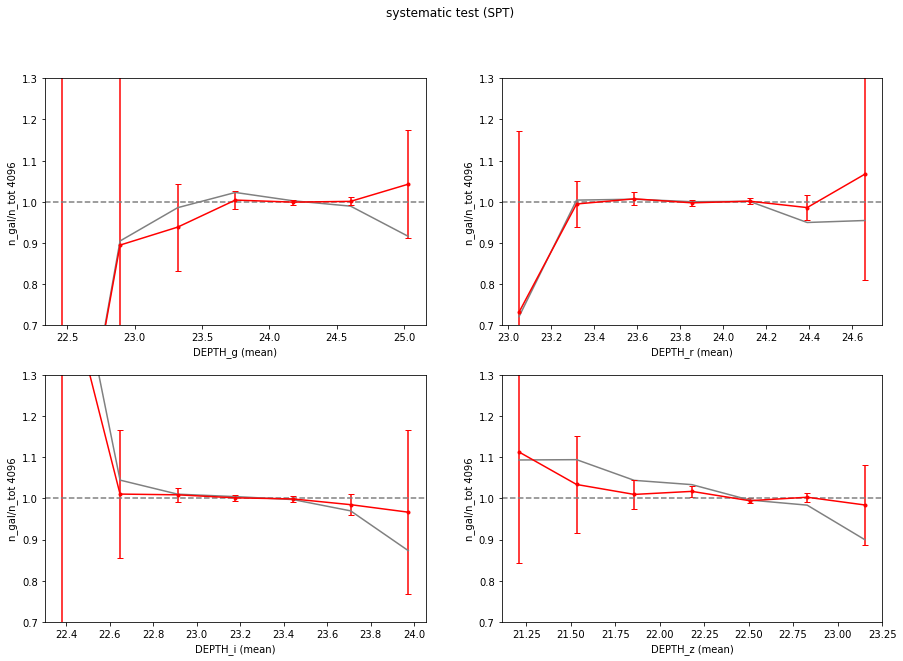

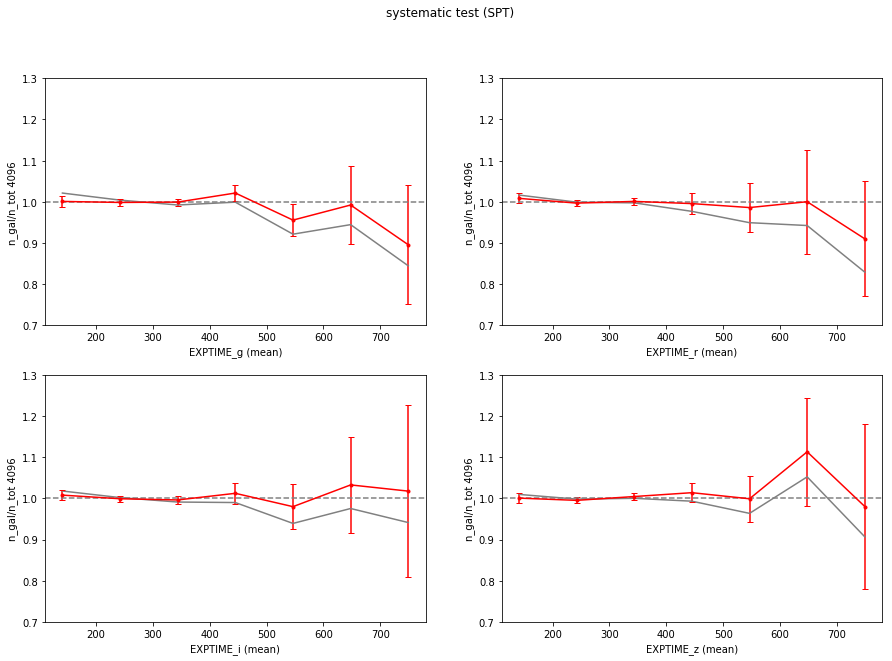

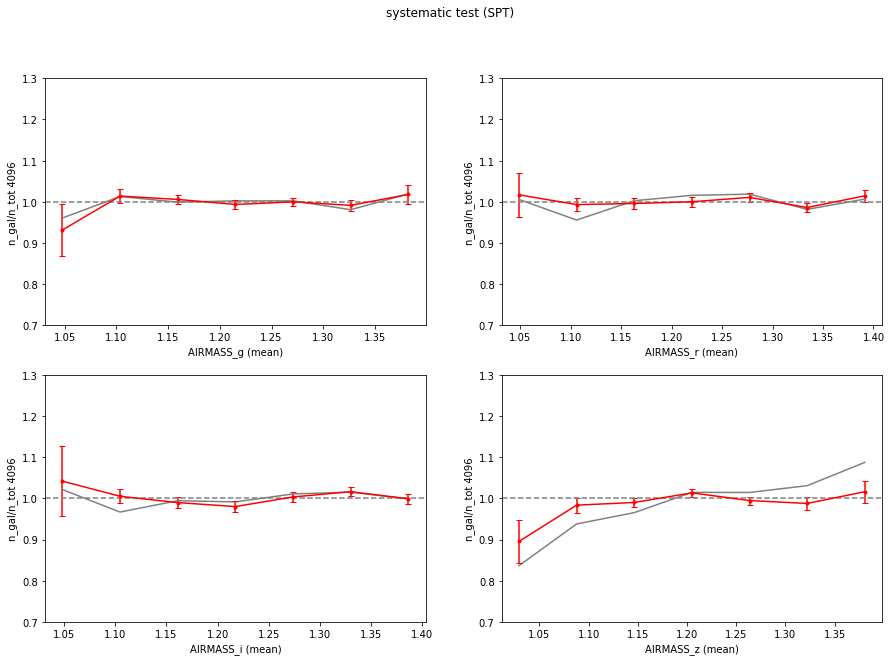

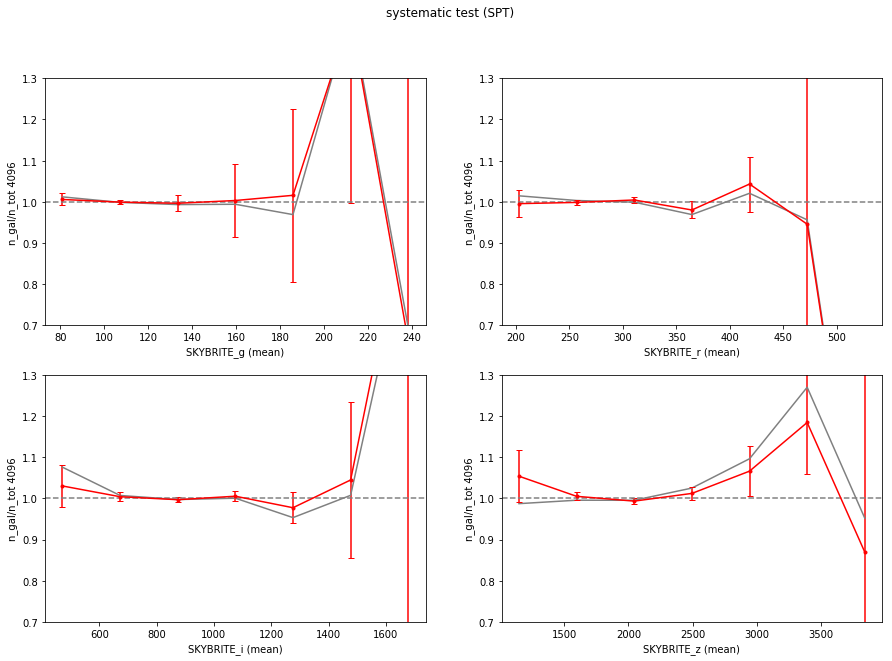

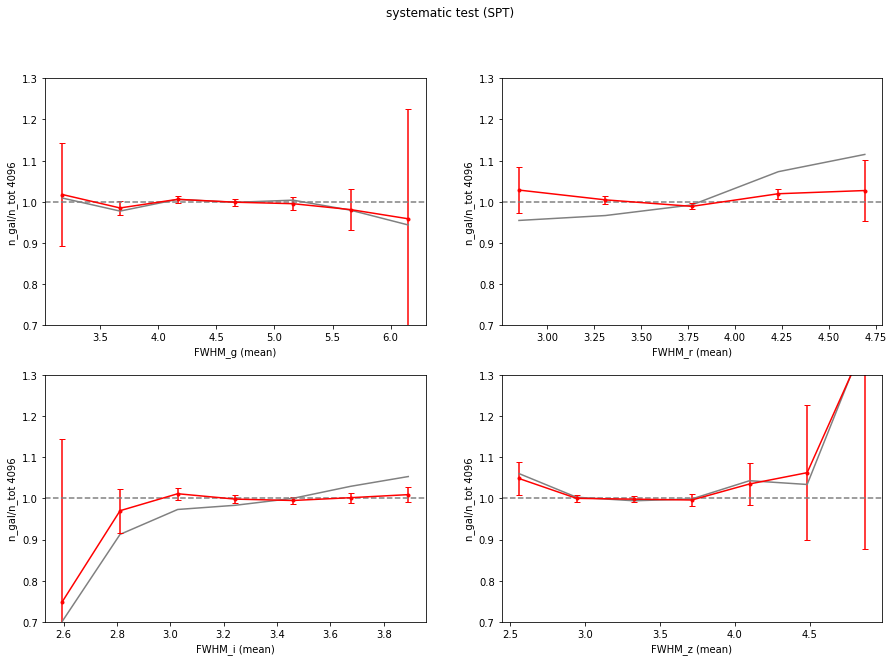

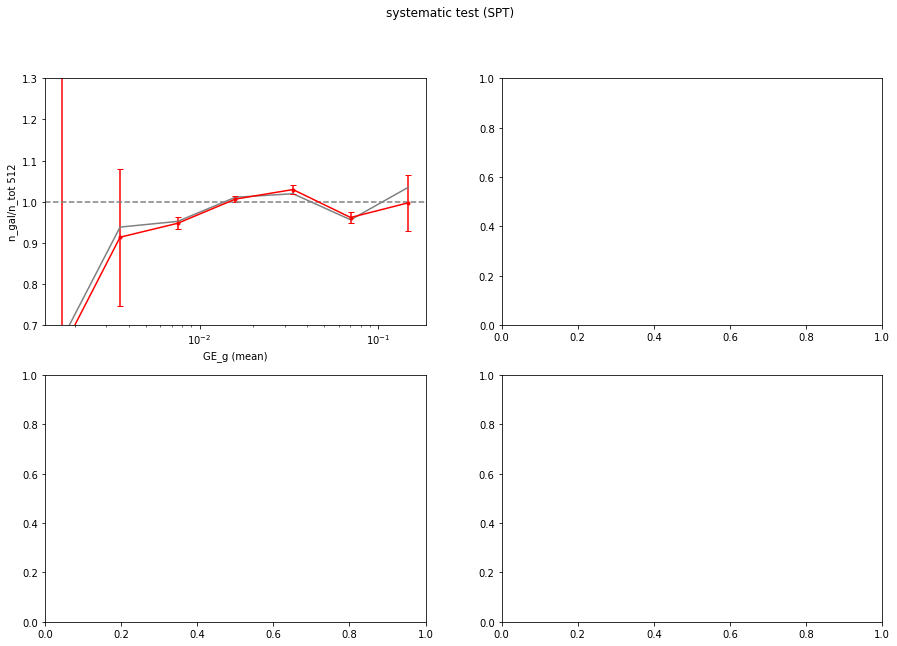

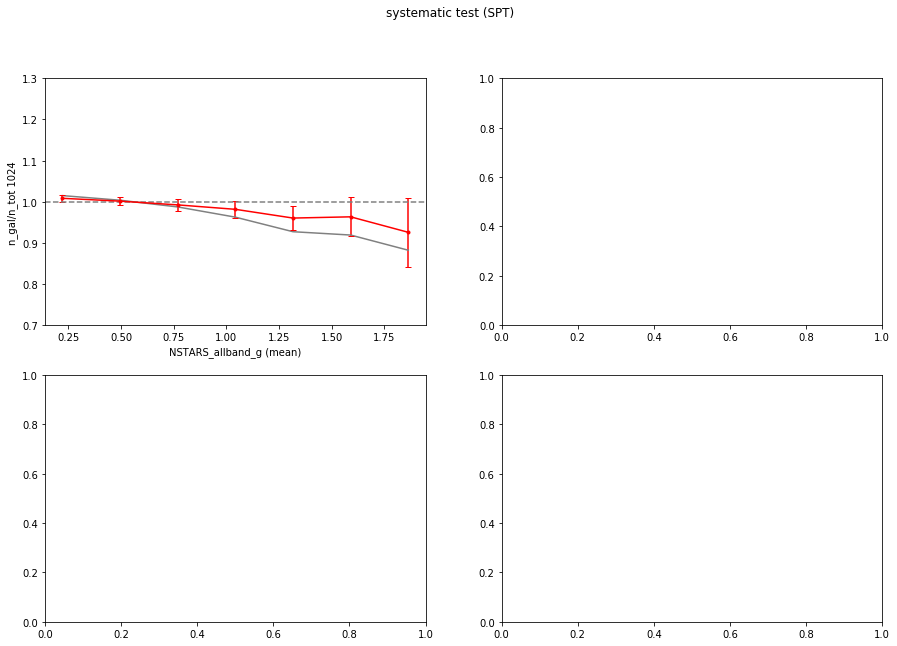

In [38]:
from run_systematics import plot_sysweight
for pr in properties + ['GE', 'NSTARS_allband']:
    plot_sysweight(property = pr, nside = 4096, kind = 'SPT', 
               suffix1='vetoed', suffix2=suf, inputdir1 = sysoutdir, inputdir2 = sysoutdir, outdir=figoutdir)



In [99]:
weightslist = [fitsio.read(wdir+'wg_'+o+'_SPT.fits') for o in order]
#all_weight = np.ones(weightslist[0].size)

In [41]:
maskedGoldMask_spt = maskingCatalogSP(catalog=GoldMask_spt, sysMap=sysMap)

6153627 6030163
mask  0.9799363854845281


In [42]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)

6777228 6641688
mask  0.9800006728414626


In [60]:
rand_no_mask = io.SearchAndCallFits(path = rootdir, keyword='random_x50_dmass_spt.fits')


--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt.fits


In [ ]:
#tree corr
from systematics_module.corr import angular_correlation
from systematics_module.corr import angular_correlation_poisson

pcut1 = (dmass['EachProb_CMASS'] > 0.01)
pcut2 = (dmass_masked['EachProb_CMASS'] > 0.01)

"""
dmass['WEIGHT'] = dmass['CMASS_PROB']
angular_correlation(data = dmass[pcut1], rand = rand_no_mask, 
                    nbins=10, weight = [True, None], njack = 100, 
                    suffix = '_dmass_no_weight_pcut01_nbins10_jk100', dir = basedir)

dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['VETO']
angular_correlation(data = dmass[pcut1], rand = rand2, nbins=10, 
                    weight = [True, None], njack = 100, 
                    suffix = '_dmass_vetoed_pcut01_nbins10_jk100', dir = basedir)

"""
"""

dmass['WEIGHT'] = dmass['CMASS_PROB']
angular_correlation_poisson(data = dmass[pcut1], rand = rand_no_mask, 
            nbins=10, weight_data = True, 
            suffix = '_dmass_no_weight_pcut01_nbins10_jk100', dir = basedir)


dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['VETO']
angular_correlation_poisson(data = dmass[pcut1], rand = rand2, 
            nbins=10, weight_data = True, 
            suffix = '_dmass_vetoed_pcut01_nbins10_jk100', dir = basedir)

"""

weight_com = dmass['CMASS_PROB']
#dmass['WEIGHT'] = weight_com

print 'initial', np.sum(dmass['WEIGHT'][pcut1]), np.sum(dmass['EachProb_CMASS'][pcut1])
for i in range(1,len(weightslist)+1):
    
     
    #for w in weightslist[:i]: weight_com *= w
    print i, order[i-1]
    weight_com *= weightslist[i-1]
    dmass['WEIGHT'] = weight_com
    #dmass_m = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
    #rand_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)
    
    
    #randind = np.random.choice( rand2.size, size = rand2.size/10)
    #rand_masked = rand2[randind]
    #dmass_m = dmass[randind]
    #pcut = (dmass_m['EachProb_CMASS'] > 0.01)
    
    if i > 0 :       
        
        angular_correlation(data = dmass[pcut1], rand = rand2, nbins=10, weight = [True, None], njack = 100, 
                            suffix = '_dmass_weight'+str(i-1)+'_pcut01_nbins10_jk100', dir = basedir)
        #angular_correlation_poisson(data = dmass[pcut1], rand = rand2, 
        #                nbins=10, weight_data = True, 
        #                suffix = '_dmass_weight'+str(i-1)+'_pcut01_nbins10_jk100', dir = basedir)
    else : pass
    

initial 117292.90214602613 117292.90214602613
1 fwhm_r
calculate angular correlation function
X (1656, 2)  centers (100, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [14 27 17 21 12 19  8 22 20 12 13  9 11 15  8  6 14 20 17 18 18 14 13 10
 14 14 17 15 15 22 20  6 23 28 13 26 11 15 13 14 18 22  8 18  9  8 19  5
 22 14 16 16 12 10 11 12 23 14 10  8 29 36  8 19  9 25 27  9 22 20 20 16
 12 24 21 19 14 16 25 17 14 24 17 13 20 20 16 17 15 26 21 23 15 24 13 17
  9 22 14 29]
X (685616, 2)  centers (100, 2)  tol=1e-05  maxiter=200
106 iterations  cluster sizes: [7814 8231 7799 7503 4742 7853 6046 7850 4968 4244 5320 8343 6710 5471
 6742 4769 6551 6898 8227 8871 5703 7248 5125 7063 6672 7426 6562 7411
 7087 8179 8376 2899 7305 7279 4957 7755 7713 5166 5848 6657 7803 9616
 7044 7454 5497 7760 4928 6166 8161 6193 7281 8312 7340 6517 6721 7298
 7877 3260 6465 7805 8789 8429 7532 6451 5974 7384 7341 7595 6273 7196
 5067 6917 3382 8348 6940 8455 5496 7003 7897 5409 8316 7728 7257 5650
 65

Text(0,0.5,'$\\omega(\\theta)$')

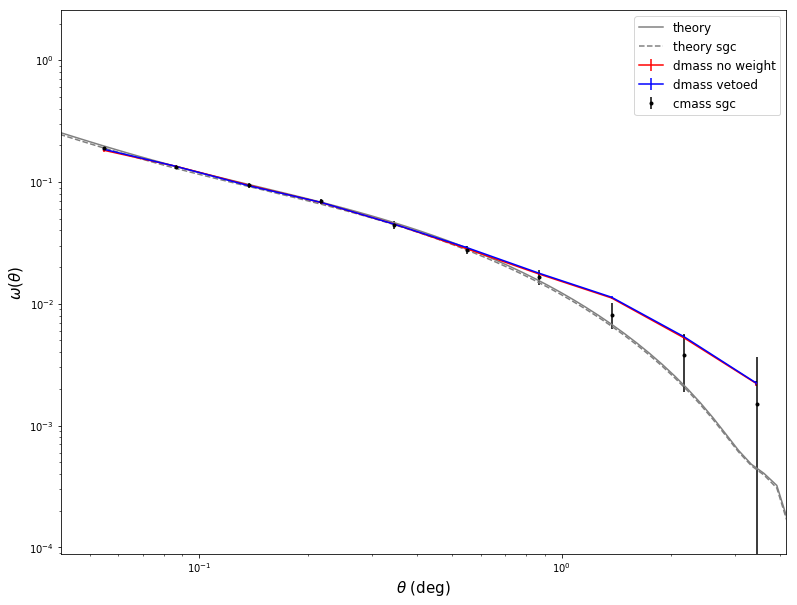

In [62]:
import scipy

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_poisson_dmass_no_weight_pcut01_nbins10_jk100.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(rootdir+'/act//acf_auto_poisson_dmass_vetoed_pcut01_nbins10_jk100.txt', unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))


ax.errorbar(meanr, xi, yerr = xi_err, fmt = '-', color='r', label='dmass no weight')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='b', label='dmass vetoed')
#ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='dmass all weight')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k.', color='r', label='cmass sgc')

ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)
0

In [16]:
def chisquare_calculation(xi1, xi2, F):
    
    diff = (xi1 - xi2)
    chi2 = np.dot(np.dot(diff, F), diff.T)
    
    return chi2

../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//act/acf_auto_poisson_dmass_no_weight_pcut01_nbins10_jk100.txt
err db, db / br1, brmin, br2 : 0.02812350576586664 0.011620280984676157 0.9917039353249879 1.005844095508292 1.0198274410908545
../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//act/acf_auto_poisson_dmass_vetoed_pcut01_nbins10_jk100.txt
err db, db / br1, brmin, br2 : 0.028075874056603056 0.006568815952606943 0.9891590808042089 1.0032952308588199 1.017234954860812
../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//act/acf_auto_poisson_dmass_weight0_pcut01_nbins10_jk100.txt
err db, db / br1, brmin, br2 : 0.027984277331866036 0.0017181275584334799 0.9867698530805397 1.0008598024043196 1.0147541304124057
../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//halfNbin//act/acf_auto_poisson_dmass_weight1_pcut01_nbins10_jk100.txt
err db, db / br1, brmin, br2 : 0.02803431379478638 0.006648041403586991 0.989239970

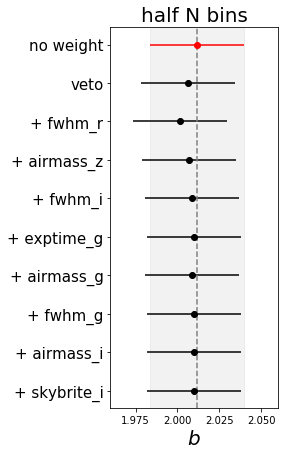

In [33]:
from systematics import brel_chisqr_fitting
import scipy


theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.5, 1.5, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)



meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')


labels_SP = ['no weight', 'veto'] + ['+ '+o for o in order]#[1:] ]

filenames = [ basedir+ 'acf_auto_poisson_dmass_no_weight_pcut01_nbins10_jk100.txt', \
              basedir + 'acf_auto_poisson_dmass_vetoed_pcut01_nbins10_jk100.txt'
            ] \
+[ basedir+'acf_auto_poisson_dmass_weight'+str(j)+'_pcut01_nbins10_jk100.txt' for j in range(0, len(labels_SP)-2)]

covnames = [ basedir+ 'acf_auto_dmass_no_weight_pcut01_nbins10_jk100.cov', \
              basedir + 'acf_auto_dmass_vetoed_pcut01_nbins10_jk100.cov'
           ] \
+[ basedir+'acf_auto_dmass_weight'+str(j)+'_pcut01_nbins10_jk100.cov' for j in range(0, len(labels_SP)-2)]


chisquare_list = []
for j in range(1, len(labels_SP)+1):
#for j in [1,7]:
    
    print filenames[j-1]
    meanrw, xiw, xi_errw = np.loadtxt( filenames[j-1], unpack=True)
    #cov_dmass_w = np.loadtxt( covnames[j-1], unpack=True)
    cov_dmass_w = np.loadtxt( covnames[1], unpack=True)
    #meanrw, xiw, xi_errw = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt', unpack=True)
    #cov_dmass_w = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov', unpack=True)
    HFd = HF(100, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    #F_s = np.linalg.inv(cov_cmass_s)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp(meanrw), F_d, verbose=True)
    #err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, xi_sgc, F_s, verbose=True)
    
    #chi2 = chisquare_calculation(xiw, xi_sgc, F_s)
    chi2 = chisquare_calculation(xiw, theory_sgc_interp(meanrw), F_d)
    chisquare_list.append( chi2/xiw.size )
    
    if j == 1 : 
        color = 'red'
        ax.axvspan(2*brelw - err_brelw*2., 2*brelw + err_brelw*2.,  alpha=0.1, color='grey')
        ax.axvline(x=2*brelw, color = 'grey', ls='--')
        #ax.axvspan(- err_brelw*2.,  err_brelw*2.,  alpha=0.1, color='grey')
        #ax.axvline(x=0, color = 'grey', ls='--')
    else : color = 'k'  
        
    ax.errorbar(2*brelw, len(labels_SP)+1-j, xerr =err_brelw*2., fmt='-o', color=color)
    
#ax.set_xlabel(r'$\Delta b = b_{fid} - b_x$', fontsize = 20)
ax.set_xlabel(r'$b$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
ax.set_xlim(1.96, 2.06)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(1, len(labels_SP)+1 ))

labels = labels_SP[::-1]
ax.set_yticklabels( labels, fontsize = 15) 
#fig.savefig(figoutdir + 'sys_bias_weight.png')
#print 'pic save to ', figoutdir + 'sys_bias_weight.png'



ax.set_title('half N bins', fontsize = 20)



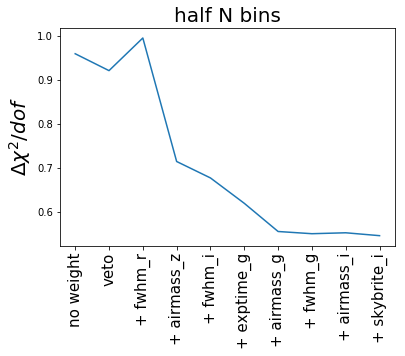

In [36]:
fig, ax = plt.subplots()

ax.plot( np.arange(10), chisquare_list )

#ax.set_xlabel(r'$\Delta b = b_{fid} - b_x$', fontsize = 20)
ax.set_ylabel(r'$\Delta \chi^2/ dof$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
#ax.legend(loc=1)
#ax.set_xlim(1.96, 2.06)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticks(np.arange(0, len(labels_SP) ))

labels = labels_SP
ax.set_xticklabels( labels, fontsize = 15, rotation=90) 
ax.set_title('half N bins', fontsize = 20)